# AER Tesseract Extraction

This notebook extracts the references and affiliations of papers from AER using the Tesseract OCR library and  

Inputs:
Outputs:

## Load Libraries

In [1]:
import fitz

# for OCR using PyTesseract
import cv2                              # pre-processing images
import pytesseract                      # extracting text from images
import numpy as np
import matplotlib.pyplot as plt         # displaying output images
from PIL import Image
import regex
import pandas as pd
import time
import os

# Load in Merged excel file


In [2]:
base_path="/Users/sijiawu/Work/Refs Danae/Thesis/Data"
temp=base_path+'/PDFs/AER/'

In [3]:
Merged=pd.read_excel(base_path+'/Combined/AER_M_sco_du.xlsx')
Merged.loc[Merged['journal']=="The American Economic Review",'journal']='AER'

In [81]:
investigate=Merged[(Merged.year<=1970)&(Merged.year>1960)&(Merged.content_type!="MISC")&(Merged.content_type!="Review")]



These dumbasses formatted the special issues differently from the normal issues. What the FUCK.

In [82]:
print(investigate[['year','type','number']].value_counts())

year  type  number
1965  N     1-2       84
1966  N     1-2       80
1970  S     2         73
1967  S     2         65
1969  S     2         63
1961  S     2         62
1963  S     2         62
1964  S     3         62
1962  S     2         60
1968  S     2         60
1970  N     3         36
1969  N     5         34
1970  N     5         32
            1         31
1969  N     4         30
            1         29
            3         28
1968  N     3         28
            4         27
1967  N     5         27
            1         25
1970  N     4         24
1967  N     4         23
1964  N     5         22
1968  N     5         22
1967  N     3         22
1966  N     3         22
1965  N     3         22
1968  N     1         21
1964  N     6         18
1962  N     5         18
1963  N     3         17
1965  N     4         17
            5         16
1966  N     4         15
1961  N     4         15
1963  N     4         15
1964  N     2         15
1961  N     1         14
      

Index([2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431,
       ...
       4382, 4383, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4391],
      dtype='int64', length=722)

In [ ]:
# printing first and last page, the assumption is these pngs already exist from the previous stage
# this for loop may also be modified to print every page
number=None
year=None
count=0
pgs=0
for i in investigate.sort_values(by=["year","number"]).index:

#     if year==None:
#         year=Merged.iloc[i]['year']
#     elif year!=Merged.iloc[i]['year']:
#         year=Merged.iloc[i]['year']
#         count=0
#     if count<3:
#         count=count+1
#     else:    
#         continue
        
        
#     if number == None:
#         number = Merged.iloc[i]['number']
#         count=count+1
#         #continue
#     elif (str(number)!=str(Merged.iloc[i]['number'])):
#         number=str(Merged.iloc[i]['number'])
#         count=1
# #         continue
#     elif (str(number)==str(Merged.iloc[i]['number']))&(count<=3):
#         count=count+1
# #         continue
#     else:
#         count=count+1
#         continue
    filepath=base_path+'/PDFs/AER/'+Merged.iloc[i]['URL'].split('/')[-1]+'.pdf'
    if os.path.exists(filepath):
        doc=fitz.open(filepath)
        print(Merged.iloc[i]['year'])
        print(Merged.iloc[i]['number'])
        print(Merged.iloc[i]['volume'])
        print(Merged.iloc[i]['author'])
        print(Merged.iloc[i]['title'])
        pgs=pgs+doc.page_count
#         for page in doc: 
#             if (page.number == 1) or (page.number==(doc.page_count-1)):
            
        png = base_path+"/PDFs/AER/png/" + Merged.iloc[i]['URL'].split('/')[-1].split('.')[0] + '_wo_cover_page-0.png'
        png2 = base_path+"/PDFs/AER/png/" + Merged.iloc[i]['URL'].split('/')[-1].split('.')[0] + '_wo_cover_page-'+str(doc.page_count-2)+'.png'
        print(png)
        #print(png2)
        if (os.path.exists(png)==True)&(os.path.exists(png2)==True):
            original_image = cv2.imread(png)

            # convert the image to grayscale
            gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

            plt.figure(figsize=(15, 8))
            plt.imshow(gray_image, cmap='gray')
            plt.show()

#             #uncomment to print last page too
#             original_image = cv2.imread(png2)

#             # convert the image to grayscale
#             gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

#             plt.figure(figsize=(15, 8))
#             plt.imshow(gray_image, cmap='gray')
#             plt.show()
    else:
        print("sorry, but this "+filepath+" was not sharded")

In [77]:
# This version ignores contouring and sectioning out paragraphs. It directly feeds the image to tesseract. 
# There seems to be no image resolution degradation this way as opposed to reduced using the openCV library.
# SCANNED_FILE: is for the full path to the original pdf. we require this to get the number of pages. 
#  The assumption is that the jstor (or other) cover page has been removed previously, so in our case it will always have wo_cover.pdf as suffix.
# path: to the folder containing pre-generated pngs, the pngs in this folder are assumed to have the same file name as the SCANNED_FILE + suffix page-{page no}.png for each sharded page
# keyword: this is whatever regex pattern that you wish to search for. This function uses the regex.search method from the regex library
#  It can take fuzzy match regex patterns
# config: this is the tesseract configuration default is '--oem 1 --psm 3', which is also the default for this function
#  3 implies automatic page segmentation, better for 2 column format pdfs, 6 assumes single column, top to bottom text and will preserve each line ending better.
def generate_refs2(SCANNED_FILE, path, keyword, custom_config = r'--oem 1 --psm 3'):
    try:
        doc = fitz.open(SCANNED_FILE)
    except:
        print("could not open: "+SCANNED_FILE)
        raise Exception("this file is corrupt")
    if "wo_cover" not in SCANNED_FILE:
        print("warning, the file: "+SCANNED_FILE.split('/')[-1]+" does not have it's coverpage removed.\nThis function will continue. Assumed image file name convention is: "+SCANNED_FILE.split('/')[-1].split('.')[0] + '_page-{number}.png')
    parsed={}
    references={}
    found=0
    for page in reversed(doc):
        png = path+"/" + SCANNED_FILE.split('/')[-1].split('.')[0] + '_page-%i.png' % page.number
#             print(png)
        parsed[page.number]=[]
        references[page.number]=[]
        if os.path.exists(png)==True:
            text = pytesseract.image_to_string(png, config=custom_config)
#                 print(text)
            parsed[page.number].append(text)
            keyword_search=regex.search(keyword,text.upper())
            if keyword_search is not None:
                print('found')
                return [{'found': parsed}, {"pages":doc.page_count}]
        else:
            print("error: this image does not exist, please generate png shards at 300 dpi in path: "+path)
    print("the keyword: "+keyword + "was not found. But this is the full tesseract output nonetheless.")
    return {'raw': parsed}

In [78]:
dict_ref={}


In [79]:
t0=time.time()
custom_config = r'--oem 1 --psm 3'

for i in Merged[(Merged['year']<=1980) & (Merged['year']>1970)& (Merged['content_type']!='MISC') & (Merged['content_type']!='Review')].index:
    filepath=temp+'wo_cover/'+Merged.iloc[i]['URL'].split('/')[-1]+'_wo_cover.pdf'
    print(filepath)
    if os.path.exists(filepath)==True:
        #print(Merged.iloc[i][['year','number','volume', 'URL']])
        references=generate_refs2(filepath, temp+"png", '(^|\n)R(EFERENCES){e<=3}(\n| )', custom_config)
        dict_ref[Merged.iloc[i]['URL'].split('/')[-1]]={'references':references, 'URL': Merged.iloc[i]['URL']}
    else:
        dict_ref[Merged.iloc[i]['URL'].split('/')[-1]]='PDF not available, download at '+ Merged.iloc[i]['URL']
t1=time.time()
total=t1-t0
print(total)
print(i)

/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1805765_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1805766_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1805767_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1805768_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1805769_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1805770_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1805771_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1805772_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1805773_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1805774_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1805775_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/T

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1805247_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1805248_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1805249_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815430_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815431_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815432_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815433_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815434_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output 

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815499_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815500_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815501_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815502_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815503_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815504_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815505_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815506_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815507_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815508_wo_cover.pdf
found
/Users/sijiaw

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808715_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808716_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808717_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808718_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808719_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808720_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808721_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808722_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808723_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808724_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808725_wo_cover.pdf
found
/Users/sijiawu/Work/Refs D

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1801658_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1801659_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1801660_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1801661_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1801662_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1801663_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1801664_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1801665_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1801666_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1801667_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1801668_wo_cover.pdf
found
/Users/sijiawu/Work/Refs D

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808935_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808936_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808937_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808938_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808939_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808940_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808941_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808942_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808943_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808944_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1808945_wo_cover.pdf
found
/Users/sijiawu/Work/Refs D

the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816695_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816696_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816697_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816698_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816699_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816700_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816701_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816702_wo_cov

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828077_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828078_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828079_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828080_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828081_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828082_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828083_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828084_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828085_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828086_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828087_wo_cover.pdf
found
/Users/sijiawu/Work/Refs D

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1807237_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1807238_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1807239_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1807240_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1807241_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1807242_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1807243_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1807244_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1807245_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1807246_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1807247_wo_cover.pdf
found
/Users/sijiawu/Work/Refs D

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815934_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815935_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815936_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815937_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815938_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815939_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815940_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815941_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815942_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1827487_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1827488_wo_cover.pdf
found
/Users/sijiawu/Work/Refs D

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828175_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828176_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828177_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828178_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828179_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828180_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828181_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828182_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828183_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1828184_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1817192_wo_cover.pdf
found
/Users/sijiawu/Work/Refs D

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804942_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804943_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804944_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804945_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804946_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804947_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804948_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804949_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804950_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804951_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804952_wo_cover.pdf
found
/Users/sijiawu/Work/Refs D

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804842_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804843_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804844_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804845_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804846_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804847_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804848_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804849_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804850_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804851_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1804852_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e

the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1818881_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1818882_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1818883_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1818884_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1818885_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1818886_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1818887_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tess

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813324_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813325_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813326_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813327_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813328_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813329_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813330_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813331_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813332_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813333_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813334_wo_cover.pdf
found
/Users/sijiawu/Work/Refs D

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816041_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816042_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816043_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816044_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816045_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816046_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816047_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816048_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816049_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816050_wo_cover.pdf
found
/Users/sijiaw

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813923_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813924_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813925_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813926_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813927_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813928_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813929_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813930_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813931_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813932_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1813933_wo_cover.pdf
found
/Users/sijiawu/Work/Refs D

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1817062_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1817063_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1817064_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1817065_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1817066_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1817067_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1817068_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1817069_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1817070_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1817071_wo_cover.pdf
the keyword: (^|
)R

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815204_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815205_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815206_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815207_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815208_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815209_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815210_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815211_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815212_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1815213_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiaw

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1803394_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1803395_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1803396_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1803397_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1803398_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1803399_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1803400_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1803401_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1803402_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1803403_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1803404_wo_cover.pdf
found
/Users/sijiawu/Work/Refs D

the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1821541_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1821542_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1821543_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1821544_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1821545_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1821546_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1821547_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tess

found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1811857_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1811858_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1811859_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1811860_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1811861_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1811862_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1811863_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1811864_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1811865_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1811866_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1811867_wo_cover.pdf
found
/Users/sijiawu/Work/Refs D

the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816993_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816994_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816995_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816996_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816997_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1816998_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1

the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1910567_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1910568_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1910569_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1910570_wo_cover.pdf
found
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1910571_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1910573_wo_cover.pdf
the keyword: (^|
)R(EFERENCES){e<=3}(
| )was not found. But this is the full tesseract output nonetheless.
/Users/sijiawu/Work/Refs Danae/Thesis/Data/PDFs/AER/wo_cover/1

In [80]:
import json
with open(base_path+'\AER_refs_output_1971_1980.json','w') as fp:
    json.dump(dict_ref, fp)

### Findings from investigations of pre-1969 (inclusive papers)
1. Anything in the communications section no longer has it's own page start and page ending. References are at the end and author affiliations are also at the end just before references denoted by asterisk and after the author name.
2. Normal length articles still get their own start and ending page with the affiliations in the footnotes and the references at the end. author names and affiliations have asterisks.
3. Book reviews sometimes do have references. Affiliations at the end just after author name
4. Discussions do not have any affiliations.
5. 1969 is possibly a manual issue. Because it is the only year with a combination of two columns and articles that run on after each other.

### Heuristics for identifying affiliations and references belonging to a document page
1. Search for communications heading in data set then split each issue by communications and normal articles.
2. Separate by special and normal issues and apply separate rule for special issues.

Alternative is to identify author name line with asterisk ending and the search for next occurence of asterisk. I don't find this fool proof because tesseract has issues identifying asterisks correctly.

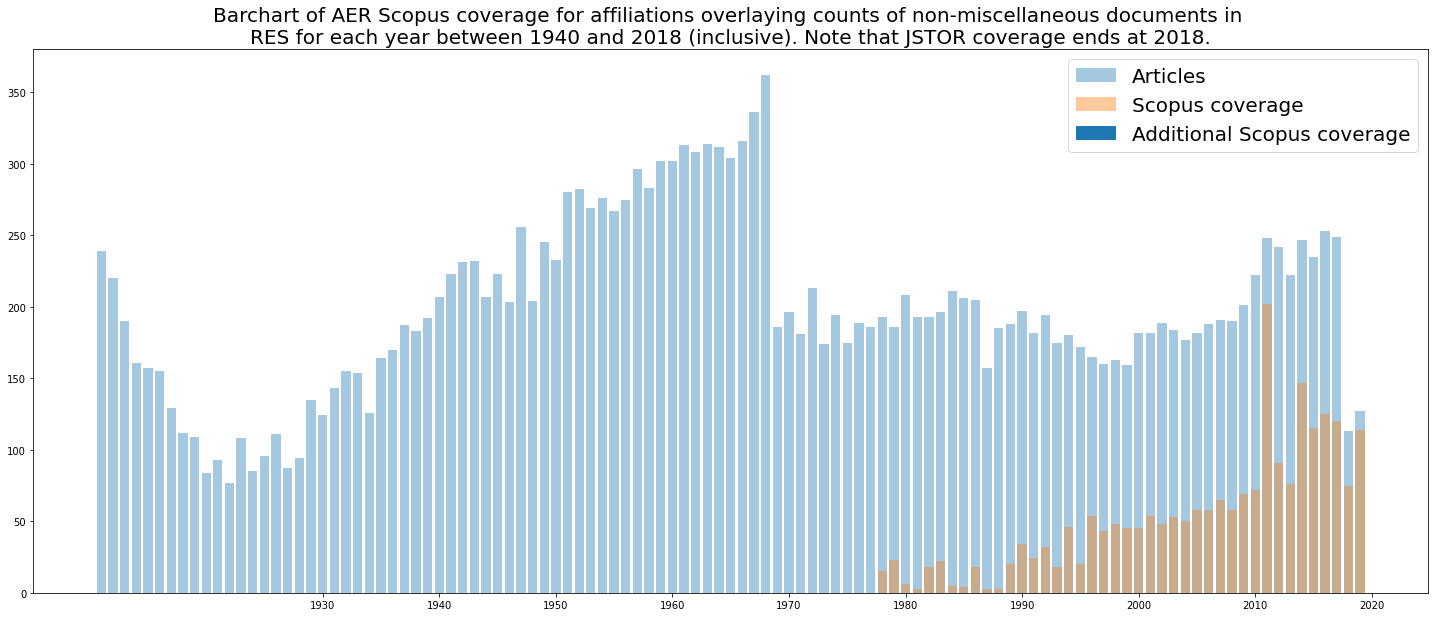

In [27]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged[(Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta.index,dta, label='Articles', alpha=0.4)
dta2=Merged[(Merged['affiliations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
dta3=Merged[(Merged['citations'].isnull()==False) & (Merged['year']>2019)]['year'].value_counts()
plt.bar(dta2.index, dta2, label='Scopus coverage', alpha=0.4)
plt.bar(dta3.index, dta3, label='Additional Scopus coverage', alpha=0.4)
plt.title('Barchart of AER Scopus coverage for affiliations overlaying counts of non-miscellaneous documents in \nRES for each year between 1940 and 2018 (inclusive). Note that JSTOR coverage ends at 2018.', fontsize=20)
plt.xticks(np.arange(1930, 2030, 10))
plt.legend(prop={'size': 20})

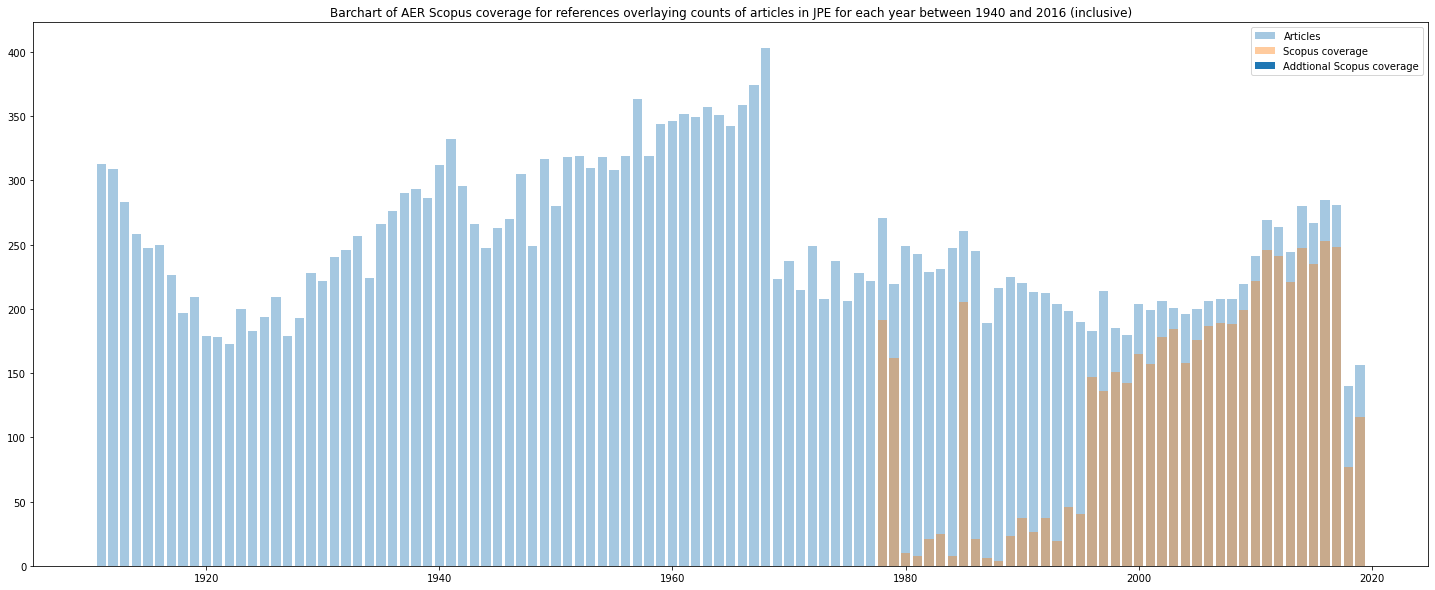

In [29]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged['year'].value_counts()
dta.index
plt.bar(dta.index, dta, alpha=0.4, label='Articles')
dta4=Merged[(Merged['citations'].isnull()==False) & (Merged['content_type']!='MISC')]['year'].value_counts()
plt.bar(dta4.index, dta4, alpha=0.4, label='Scopus coverage')
dta5=Merged[(Merged['citations'].isnull()==False) & (Merged['year']>2019)]['year'].value_counts()
plt.bar(dta5.index, dta5, alpha=0.4, label='Addtional Scopus coverage')
plt.title('Barchart of AER Scopus coverage for references overlaying counts of articles in JPE for each year between 1940 and 2016 (inclusive)')
plt.legend()



## The Tesseract library
I use Tesseract, a popular parsing library and the python binding of it pyTesseract to parse JPE documents in this section. I am following the code and technique from this article on how to read a multi-column pdf. The fitz python module is a lightweight pdf reader, it will require the installation of pyMupdf. OpenCV python module and the module/class cv2 from it is used to apply otsu's thresholding technique to lift/determine paragraph edges.

https://towardsdatascience.com/read-a-multi-column-pdf-with-pytesseract-in-python-1d99015f887a


In [30]:
import fitz

# for OCR using PyTesseract
import cv2                              # pre-processing images
import pytesseract                      # extracting text from images
import numpy as np
import matplotlib.pyplot as plt         # displaying output images
import regex
from PIL import Image

In [37]:
# replace with you own file
#https://pymupdf.readthedocs.io/en/latest/app1.html#text-extraction-flags
SCANNED_FILE = fpath+'\\41038753.pdf'
SCANNED_FILE

'D:\\docs\\Masters\\Data\\AER_data\\41038753.pdf'

Set the zoom factor to zoom into the pdf. This is to get a higher resolution image. I have chosen 2x zoom for both vertically and horizontally.

In [35]:
zoom_x = 3.0 # horizontal zoom
zoom_y = 3.0 # vertical zoom
mat = fitz.Matrix(zoom_x, zoom_y)

Given a text string from jstor of the page numbers of an article, this gives the number of pages expected in the article. Because some articles' pdfs are downloaded from scopus sometimes they are missing a front page. On the otherhand sometimes jstor has a coverpage that is not accounted for. This function returns the number of pages so that the first page of an article can be correctly identified.

This function replaces all initials and non-ascii characters with placeholders. This is used on author names.

In [8]:
import string
def converter(teststring):
    for i in range(len(teststring)):
        if teststring[i] == '.':
            teststring=teststring[0:i-1]+'.'+teststring[i:]
    
    #teststring=teststring.replace('I','.')
            
    for i in teststring:
        if (i not in string.ascii_lowercase) & (i not in string.ascii_uppercase) & (i !=' '):
            teststring=teststring.replace(i,'.')
    return teststring

In [9]:
def generate_pngs4(SCANNED_FILE, pages, mat, path, k_val, keyword):
    doc = fitz.open(SCANNED_FILE)
    parsed={}
    for page in reversed(doc):
        if page.number==0:
            break
        png = path+"\\" + SCANNED_FILE.split('\\')[-1].split('.')[0] + '_page-%i.png' % page.number
        print(png)
        if os.path.exists(png)==False:
            pix = page.get_pixmap(matrix=mat)
            pix.save(png)
        parsed[page.number]=[]
        
        original_image = cv2.imread(png)
        # convert the image to grayscale
        gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

        #plt.figure(figsize=(25, 15))
        #plt.imshow(gray_image, cmap='gray')
        #plt.show()

        # Performing OTSU threshold
        ret, threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

        #plt.figure(figsize=(25, 15))
        #plt.imshow(threshold_image, cmap='gray')
        #plt.show()

        rectangular_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_val, k_val))

        # Applying dilation on the threshold image
        dilated_image = cv2.dilate(threshold_image, rectangular_kernel, iterations = 1)

        #plt.figure(figsize=(25, 15))
        #plt.imshow(dilated_image)
        #plt.show()

        # Finding contours
        contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Creating a copy of the image
        copied_image = original_image.copy()
        margin=copied_image.shape[1]/3
        mask = np.zeros(original_image.shape, np.uint8)
        i=1
        # Looping through the identified contours
        # Then rectangular part is cropped and passed on to pytesseract
        # pytesseract extracts the text inside each contours
        # Extracted text is then written into a text file
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            #print(str(x)+' '+str(y)+' '+str(w)+' '+str(h))
            print(i)
            # Cropping the text block for giving input to OCR
            cropped = copied_image[y:y + h, x:x + w]
            # Apply OCR on the cropped image
            text = pytesseract.image_to_string(cropped, lang='lat', config='--oem 3 --psm 4')
            print(text)
            
            if text=='':
                continue
            if regex.search('^(THIS CONTENT DOWLOADED){e<=3}', text.upper()):
                continue
            if regex.search('AUTHOR\(S\)', text.upper()) is not None:
                break
            parsed[page.number].append(text)
            #print(re.search(keyword,text.upper()))
            if (regex.search(keyword,text.upper()) is not None):
                return {'found': text, 'raw':parsed}
            #masked = cv2.drawContours(mask, [cnt], 0, (255, 255, 255), -1)
            print()
            i=i+1
        #plt.figure(figsize=(25, 15))
        #plt.imshow(masked, cmap='gray')
        #plt.show()
    return {'raw': parsed}

In [10]:
def generate_pngs3(SCANNED_FILE, pages, mat, path, k_val, keyword):
    doc = fitz.open(SCANNED_FILE)
    parsed={}
    count=doc.page_count-pages
    if count<0:
        count=1
    for page in doc:
        if (page.number == count):
            png = path+"\\" + SCANNED_FILE.split('\\')[-1].split('.')[0] + '_page-%i.png' % page.number
            print(png)
            if os.path.exists(png)==False:
                pix = page.get_pixmap(matrix=mat)
                pix.save(png)
            parsed[page.number]=[]

            original_image = cv2.imread(png)
            # convert the image to grayscale
            gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(gray_image, cmap='gray')
            #plt.show()

            # Performing OTSU threshold
            ret, threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(threshold_image, cmap='gray')
            #plt.show()

            rectangular_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_val, k_val))

            # Applying dilation on the threshold image
            dilated_image = cv2.dilate(threshold_image, rectangular_kernel, iterations = 1)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(dilated_image)
            #plt.show()

            # Finding contours
            contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            # Creating a copy of the image
            copied_image = original_image.copy()
            margin=copied_image.shape[1]/3
            mask = np.zeros(original_image.shape, np.uint8)
            i=1
            # Looping through the identified contours
            # Then rectangular part is cropped and passed on to pytesseract
            # pytesseract extracts the text inside each contours
            # Extracted text is then written into a text file
            for cnt in reversed(contours):
                x, y, w, h = cv2.boundingRect(cnt)
                #print(str(x)+' '+str(y)+' '+str(w)+' '+str(h))
                print(i)
                # Cropping the text block for giving input to OCR
                cropped = copied_image[y:y + h, x:x + w]
                # Apply OCR on the cropped image
                text = pytesseract.image_to_string(cropped, lang='lat', config='--oem 3 --psm 4')
                print(text)
                parsed[page.number].append(text)
                
                if re.search('AUTHOR\(S\)', text.upper()) is not None:
                    count+=1
                    break
                #print(re.search(keyword,text.upper()))
                if re.search(keyword,text.upper()) is not None:
                    #if x>margin:
                    #    continue
                    return {'found': text}
                #masked = cv2.drawContours(mask, [cnt], 0, (255, 255, 255), -1)
                print()
                i=i+1
            #plt.figure(figsize=(25, 15))
            #plt.imshow(masked, cmap='gray')
            #plt.show()
    return {'raw': parsed}

In [11]:
def generate_pngs2(SCANNED_FILE, pages, mat, path, k_val, keyword):
    doc = fitz.open(SCANNED_FILE)
    parsed={}
    count=doc.page_count-pages
    if count<0:
        count=1
    for page in doc:
        if (page.number == count):
            png = path+"\\" + SCANNED_FILE.split('\\')[-1].split('.')[0] + '_page-%i.png' % page.number
            print(png)
            if os.path.exists(png)==False:
                pix = page.get_pixmap(matrix=mat)
                pix.save(png)
            parsed[page.number]=[]

            original_image = cv2.imread(png)
            # convert the image to grayscale
            gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(gray_image, cmap='gray')
            #plt.show()

            # Performing OTSU threshold
            ret, threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(threshold_image, cmap='gray')
            #plt.show()

            rectangular_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_val, k_val))

            # Applying dilation on the threshold image
            dilated_image = cv2.dilate(threshold_image, rectangular_kernel, iterations = 1)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(dilated_image)
            #plt.show()

            # Finding contours
            contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            # Creating a copy of the image
            copied_image = original_image.copy()
            margin=copied_image.shape[1]/3
            mask = np.zeros(original_image.shape, np.uint8)
            i=1
            # Looping through the identified contours
            # Then rectangular part is cropped and passed on to pytesseract
            # pytesseract extracts the text inside each contours
            # Extracted text is then written into a text file
            for cnt in reversed(contours):
                x, y, w, h = cv2.boundingRect(cnt)
                #print(str(x)+' '+str(y)+' '+str(w)+' '+str(h))
                print(i)
                # Cropping the text block for giving input to OCR
                cropped = copied_image[y:y + h, x:x + w]
                # Apply OCR on the cropped image
                text = pytesseract.image_to_string(cropped, lang='lat', config='--oem 3 --psm 1')
                print(text)
                parsed[page.number].append(text)
                
                if re.search('AUTHOR\(S\)', text.upper()) is not None:
                    count+=1
                    break
                #print(re.search(keyword,text.upper()))
                if re.search(keyword,text.upper()) is not None:
                    #if x>margin:
                    #    continue
                    return {'found': text}
                #masked = cv2.drawContours(mask, [cnt], 0, (255, 255, 255), -1)
                print()
                i=i+1
            #plt.figure(figsize=(25, 15))
            #plt.imshow(masked, cmap='gray')
            #plt.show()
    return {'raw': parsed}

In [12]:
def generate_pngs(SCANNED_FILE, pages, mat, path, k_val, keyword):
    doc = fitz.open(SCANNED_FILE)
    parsed={}
    count=doc.page_count-pages
    if count<0:
        count=1
    for page in doc:
        if (page.number == count):
            png = path+"\\" + SCANNED_FILE.split('\\')[-1].split('.')[0] + '_page-%i.png' % page.number
            print(png)
            if os.path.exists(png)==False:
                pix = page.get_pixmap(matrix=mat)
                pix.save(png)
            parsed[page.number]=[]

            original_image = cv2.imread(png)
            # convert the image to grayscale
            gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(gray_image, cmap='gray')
            #plt.show()

            # Performing OTSU threshold
            ret, threshold_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(threshold_image, cmap='gray')
            #plt.show()

            rectangular_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_val, k_val))

            # Applying dilation on the threshold image
            dilated_image = cv2.dilate(threshold_image, rectangular_kernel, iterations = 1)

            #plt.figure(figsize=(25, 15))
            #plt.imshow(dilated_image)
            #plt.show()

            # Finding contours
            contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            # Creating a copy of the image
            copied_image = original_image.copy()
            margin=copied_image.shape[1]/3
            mask = np.zeros(original_image.shape, np.uint8)
            i=1
            # Looping through the identified contours
            # Then rectangular part is cropped and passed on to pytesseract
            # pytesseract extracts the text inside each contours
            # Extracted text is then written into a text file
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                #print(str(x)+' '+str(y)+' '+str(w)+' '+str(h))
                print(i)
                # Cropping the text block for giving input to OCR
                cropped = copied_image[y:y + h, x:x + w]
                # Apply OCR on the cropped image
                text = pytesseract.image_to_string(cropped, lang='lat', config='--oem 3 --psm 1')
                print(text)
                parsed[page.number].append(text)
                if text=='':
                    continue
                if re.search('AUTHOR\(S\)', text.upper()) is not None:
                    count+=1
                    break
                #print(re.search(keyword,text.upper()))
                if re.search(keyword,text.upper()) is not None:
                    if x>margin:
                        continue
                    return {'found': text}
                #masked = cv2.drawContours(mask, [cnt], 0, (255, 255, 255), -1)
                print()
                i=i+1
            #plt.figure(figsize=(25, 15))
            #plt.imshow(masked, cmap='gray')
            #plt.show()
    return {'raw': parsed}

In [13]:
def get_separation(SCANNED_FILE, page_number, mat, path, keyword):
    doc = fitz.open(SCANNED_FILE)
    count=page_number
    for page in doc:
        if (page.number == count):
            png = path+"\\" + SCANNED_FILE.split('\\')[-1].split('.')[0] + '_page-%i.png' % page.number
            
            if os.path.exists(png)==False:
                pix = page.get_pixmap(matrix=mat)
                pix.save(png)

            original_image = cv2.imread(png)
            # convert the image to grayscale
            gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
            
            # Creating a copy of the image
            copied_image = original_image.copy()
            
            text = pytesseract.image_to_string(copied_image, lang='lat', config='--oem 3 --psm 4')
            if re.search('AUTHOR\(S\)', text.upper()) is not None:
                count+=1
                break
            #print(re.search(keyword,text.upper()))
            if regex.search(keyword, text) is not None:
                #print(text)
                return SCANNED_FILE
                    
    return None

In [14]:
filename=path+"\\1814031.pdf"
X=get_separation(filename, 1, mat, path, '^(COMMUNICATIONS){e<=3}\n')
print(X)

None


In [15]:
section_start=pd.DataFrame(columns=['issue_url', 'Communication_section'])

In [14]:
issues=investigate.issue_url.unique()
for a in issues:
    print(a)
    outcome=None
    temp=Merged[Merged['issue_url']==a]['stable_url'].sort_values(ascending=True)
    for i in temp.index:
        outcome=get_separation(path+"\\"+Merged.loc[i,'stable_url'].split('/')[-1]+'.pdf', 1, mat, path, '^(COMMUNICATIONS){e<=3}\n')
        if outcome is not None:
            print(Merged.loc[i,'stable_url'].split('/')[-1])
            outcome
            section_start=pd.concat([section_start, pd.DataFrame([[Merged.loc[i,'issue_url'],Merged.loc[i,'stable_url']]], columns=['issue_url','Communication_section'])])
            break
    if outcome==None:
        section_start=pd.concat([section_start, pd.DataFrame([[Merged.loc[i,'issue_url'],outcome]], columns=['issue_url','Communication_section'])])
    

NameError: name 'investigate' is not defined

In [45]:
section_start.to_excel(path+'\\communications.xlsx', index=False)

In [16]:
section_start=pd.read_excel(path+'\\communications.xlsx')

In [17]:
section_start

issue_url  \
0    https://www.jstor.org/stable/10.2307/i331420   
1    https://www.jstor.org/stable/10.2307/i331447   
2    https://www.jstor.org/stable/10.2307/i331387   
3    https://www.jstor.org/stable/10.2307/i304609   
4    https://www.jstor.org/stable/10.2307/i331466   
..                                            ...   
120  https://www.jstor.org/stable/10.2307/i304562   
121  https://www.jstor.org/stable/10.2307/i331311   
122  https://www.jstor.org/stable/10.2307/i331344   
123  https://www.jstor.org/stable/10.2307/i331343   
124  https://www.jstor.org/stable/10.2307/i331342   

                                Communication_section  
0    C:\Users\sjwu1\Journal_Data\AER_data\1810684.pdf  
1    C:\Users\sjwu1\Journal_Data\AER_data\1813220.pdf  
2    C:\Users\sjwu1\Journal_Data\AER_data\1808964.pdf  
3    C:\Users\sjwu1\Journal_Data\AER_data\1811103.pdf  
4    C:\Users\sjwu1\Journal_Data\AER_data\1814032.pdf  
..                                                ...  
120  C:\Users\sjwu1\Journal_Data\AER_data\1804235.pdf  
121  C:\Users\sjwu1\Journal_Data\AER_data\1805074.pdf  
122  C:\Users\sjwu1\Journal_Data\AER_data\1807584.pdf  
123  C:\Users\sjwu1\Journal_Data\AER_data\1807059.pdf  
124  C:\Users\sjwu1\Journal_Data\AER_data\1807646.pdf  

[125 rows x 2 columns]

In [18]:
section_start=section_start.set_index('issue_url').to_dict()['Communication_section']

In [19]:
section_start['https://www.jstor.org/stable/10.2307/i331488']

'C:\\Users\\sjwu1\\Journal_Data\\AER_data\\1815304.pdf'

In [20]:
for m in section_start.keys():
    if str(section_start[m])=='nan':
        section_start[m]=None

In [21]:
author='(^|\n)(MARK .. PAULY){e<=3}'
generate_pngs4(path+'\\1813785.pdf', 4, mat, path, 35,author)



C:\Users\sjwu1\Journal_Data\AER_data\1813785_page-7.png
1
This content downloaded from 194.214.27.178 on Wed, 31 Jul 2013 13:20:50 PM.
AII use subject to JSTOR Terms and Conditions

1
Mr. Pauly's paper [3] has enriched our understanding of the phenomenon
of so called *moral hazard" and has convincingly shown that the optimality of
complete insurance is no longer valid when the method of insurance influences
the demand for the services provided by the insurance policy. This point is
worth making strongly. In the theory of optimal allocation of resources under
risk bearing it can be shown that competitive insurance markets will yield op-
timal allocation when the events insured are not controllable by individual be-
havior. If the amount of insurance payment is in any way dependent on a
decision of the insured as well as on a state of nature, then the effect is very
much the same as that of any excise tax and optimality will not be achieved
either by the competitive system or by an attem

{'found': 'IV. Conclusion\n\nIt is possible to conclude that even if all individuals are risk-averters, some\nuncertain medical care expenses will not and should not be insured in an opti-\nmal situation. No single insurance policy is "best" or "most efficient" for a\nwhole population of diverse tastes. Which expenses are insurable is not an ob-\njective fact, but depends on the tastes and behavior of the persons involved.\n\nMank V. PAULY*\n',
 'raw': {7: ['Mr. Pauly\'s paper [3] has enriched our understanding of the phenomenon\nof so called *moral hazard" and has convincingly shown that the optimality of\ncomplete insurance is no longer valid when the method of insurance influences\nthe demand for the services provided by the insurance policy. This point is\nworth making strongly. In the theory of optimal allocation of resources under\nrisk bearing it can be shown that competitive insurance markets will yield op-\ntimal allocation when the events insured are not controllable by indiv

In [21]:
author

'(^|\n)(ROBERT PAUL THOMAS){e<=5}'

In [185]:
dict={}

In [24]:
Merged.content_type.unique()
Merged[(Merged['year']<=1968) & (Merged['year']>=1968) & (Merged['content_type']!='MISC') & (Merged['content_type']!='Review') & (Merged['content_type']!='Discussion') & (Merged['type']=='N')]['issue_url'].unique()

array(['https://www.jstor.org/stable/10.2307/i331466',
       'https://www.jstor.org/stable/10.2307/i331496',
       'https://www.jstor.org/stable/10.2307/i331465',
       'https://www.jstor.org/stable/10.2307/i331921'], dtype=object)

In [186]:
for i in Merged[(Merged['year']<=1968) & (Merged['year']>=1940) & (Merged['content_type']!='MISC') & (Merged['content_type']!='Review') & (Merged['content_type']!='Discussion') & (Merged['type']=='N')].index:
    if Merged.iloc[i]['authors_x'] is not NaN: 
        if "Suggested by" not in Merged.iloc[i]['authors_x']:
            
            authors=str(Merged.iloc[i]['authors_x']).replace(' and ',', ').replace("  ",' ').split(',')
            filepath=path+'\\'+Merged.iloc[i]['stable_url'].split('/')[-1]+'.pdf'
            indicator=None
            try:
                indicator='https://www.jstor.org/stable/'+section_start[Merged.loc[i,'issue_url']].split('\\')[-1][0:-4]
            except:
                indicator=None
            if indicator is not None:
                print(indicator)
                print(Merged.iloc[i].values[0])
                if Merged.iloc[i].values[0]<indicator:
                    print('before')
                    affiliations=generate_pngs3(filepath,getNumberofPages(Merged.iloc[i]['pages']), mat, path, 35, '(?:^\*|^\* |^"|\n\n\*|EDITOR\'S NOTE)')
                    dict[Merged.iloc[i]['stable_url'].split('/')[-1]]={'affiliations':affiliations, 'content_type':Merged.iloc[i]['content_type'], 'authors':authors, 'stable_url': Merged.iloc[i]['stable_url']}
                else:
                    author='(^|\n)('+converter(authors[0].upper())+'){e<=3}'
                    start=Merged.iloc
                    affiliations=generate_pngs4(filepath, getNumberofPages(Merged.iloc[i]['pages']), mat, path, 35,author)
                    dict[Merged.iloc[i]['stable_url'].split('/')[-1]]={'affiliations':affiliations, 'content_type':Merged.iloc[i]['content_type'], 'authors':authors, 'stable_url': Merged.iloc[i]['stable_url']}
            else:
                print('not applicable')
                affiliations=generate_pngs3(filepath,getNumberofPages(Merged.iloc[i]['pages']), mat, path, 35, '(?:^\*|^\* |^"|\n\n\*|EDITOR\'S NOTE)')
                dict[Merged.iloc[i]['stable_url'].split('/')[-1]]={'affiliations':affiliations, 'content_type':Merged.iloc[i]['content_type'], 'authors':authors, 'stable_url': Merged.iloc[i]['stable_url']}

https://www.jstor.org/stable/1805074
https://www.jstor.org/stable/1805064
before
['713-723']
C:\Users\sjwu1\Journal_Data\AER_data\1805064_page-1.png
1


2


3
The

American Economic Review


4
Vor. XXX


5
DECEMBER, 1940


6
No. 4


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30
WEHRWIRTSCHAFT: ECONOMICS OF THE MILITARY STATE

War preparation and warfare are the simple and well defined objectives of economic
planning in the military state. This type of economic organization has been called forth
by the doctrine of total war. Besides the traditional use of the military proper, total war
embraces two new weapons: psychological and economic warfare. In the economics of the
military state there is no distinct line of demarcation which separates war from peace.
War is no longer regarded as a passing stage of abnormality to be replaced in short by
normal conditions of peace; and war economics is no longer a special branch of

This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 04:04:38 UTC
AII use subject to https://about.jstor.org/terms


https://www.jstor.org/stable/1805074
https://www.jstor.org/stable/1805067
before
['748-758']
C:\Users\sjwu1\Journal_Data\AER_data\1805067_page-1.png
1


2


3


4


5


6


7


8


9


10


11


12


13
SOME CHARACTERISTICS OF SAVINGS DEPOSITS

In this paper various characteristics of savings deposits are studied in order to clarify
the functions of these deposits. (1) In the late 1920's many deposits were withdrawn for
the purchase of stocks and other investments. During the 1930's, as a rule, deposits were
not used for current spending on consumption to the extent commonly supposed. In one
depressed area, however, spending and unemployment were the main reasons for with-
drawal. (2) The activity of savings deposits is marked by sharp seasonal fluctuations, but
the annual rate of turnover is more stable than that for demand deposits. Medium-sized
balances ($4



17
? Adam Smith speaks of "tax-shifting," of "final payment," and of "burden," but does
not use the expression "incidence." The same is true of Ricardo and Mill. As subsequently
defined and used, the concept is nevertheless present in their work.

? F. R. A. Seligman, The Sbifting and Incidence of Taxation, 4th ed., revised, 1921,
p. l. (Changes appearing in the 5th edition are not significant from our standpoint,
references throughout being to the Áth edition.)

* [bid., p. 3.
*Ibid., p. 11.
^ [bid., p. 12.

* Otto Frhr. von Mering, Die Steuerueberwaelzung. His study is outstanding in Ger-
man literature on the incidence of taxation.

https://www.jstor.org/stable/1805074
https://www.jstor.org/stable/1805070
before
['787-802']
C:\Users\sjwu1\Journal_Data\AER_data\1805070_page-1.png
1


2


3


4


5


6


7


8
COMMERCIAL POLICY AS REFLECTED IN TREATIES
FROM 1931 TO 1939

Great changes have largely transformed world trade during the years from the onslaught
of the world depression to

ELASTICITY OF DEMAND COMPUTED FROM COST DATA


2


3


4


5


6


7


8


9


10


11


12


13


14
1. An individual producer striving toward maximum profit adjusts the
volume of his output so as to equate marginal revenue to his marginal
costs. Given the marginal costs C'(4) of his output at any particular point
of time and the price p(4) at which it has been sold, the elasticity

P(4) ,

qj — —— — —2 of his "individual" demand curve (4) can be derived.
qr (4)

The marginal revenue equals the marginal costs:

(1) (4) * 4  b(4) — C (4)

It follows that:

(2) s— P4) -. b(4)

q4F(41)  C(q)—Pb(4)

2. The "Analysis of Steel Prices, Volume and Costs" prepared by the
United States Steel Corporation in connection with its studies in preparation
for the hearings on the steel industry before the Temporary National Eco-
nomic Committee contains annual figures on the total revenue, output and
marginal ("variable") costs of the Steel Corporation for a period of twelve
years from 1927 to 1938.* U


2

2

2

2

2

2

2

2

2

2

2

2
of Messrs. Dice and Schaffner does not necessarily cast light on anything in the
real world except bank posting practices,? although I suspect that Messrs. Dice
and Schaffner cink that their lstinction does far more than this. But I can
see neither a general way of calculating "offset checks" nor a reason for attempting
the calculation, as I know of no important reason to distinguish between velocity
(in my sense) within an account and between accounts, which depends, as we
have seen, mainly on the length of the posting period.
HENRY H. VILLARD
Amberst College

https://www.jstor.org/stable/1805074
https://www.jstor.org/stable/1805075
['825-827']
C:\Users\sjwu1\Journal_Data\AER_data\1805075_page-3.png
1
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 04:08:23 UTC
AII use subject to https://about.jstor.org/terms

1
Pacific Gas and Electric Case: Reply

Two comments—one by Professor Bigham and one by Professor Mayer—
appear in the June i

Ms re IRALERIS VU MEM

American Institute for Economic Research

A Note on Discontinuous Cost Curves

Since the triumph of geometry and calculus over arithmetic in the exposi-
tion of economic theory, very little attention has been devoted to the question
of discontinuous cost curves.! If the actual discontinuities are minor in extent,

' The only exceptions in the modern literature (discontinuities were of course typical in
the discussions of the older Austrian economists) that are known to me are M. F. W. Joseph,
"A Discontinuous Cost Curve and the Tendency to Increasing Returns," Econ. Jour., 1933,
390-98; E. Schneider, T'2eorie der Produktion (Vienna, 1934), pp. 51-57; and S. Carlson,
A Study on tbe Pure Tbeory of Production (London, 1939), pp. 40-41, 50-52. None of these
authors discusses the kind of discontinuous cost curve here examined.


2

2

2

2
firm. Should the employer reduce his labor supply following the rise in wages,
he would find his profits less (or losses greater) 


2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2

2
te


3

3

3

3
typical) may operate at a? output which equates marginal revenue to marginal
cost. But in light of the uncertainty regarding the marginal revenue from larger
(or smaller) outputs, he may not attempt to verify that his present profits
are at maximum maxima. Systematic differences between actual and (from the
producer's viewpoint) ideal output become possible.
GzongE jJ. SrIGLER
University of Minnesota


4

4

4
835


5
1940]


6
Experience Rating in Wisconsin in 1940


C:\Users\sjwu1\Journal_Data\AER_data\1805079_page-3.png
1
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 04:10:08 UTC
AII use subject to https://about.jstor.org/terms

1
The noteworthy feature of Figure 1 is that at any given price (represented
by the line MN), marginal cost equals price at many outputs: this familiar
criterion of compctitive output is not unique when 


3
832


4
Communications


5
[December


https://www.jstor.org/stable/1805074
https://www.jstor.org/stable/1805080
['835-837']
C:\Users\sjwu1\Journal_Data\AER_data\1805080_page-3.png
1
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 04:10:33 UTC
AII use subject to https://about.jstor.org/terms

1
tinued effective stabilization efforts encouraged by the Act,? but one conclusion
of the 1937-38 field study was that, under the reserve percentage form of ex-
perience rating, many firms are able to qualify for reduced rates without any
additional effort because they happen to be in already stable businesses. If
one accepts the argument that experience rating allocates the "social costs" of
unemployment among firms, this result is desirable. On the other hand, if the
"social cost" proposition is regarded as untenable, the rewarding of firms in
naturally stable businesses is not the most effective sort of experience rating.

CHARLES A. MYERS

Massachusetts Institute of Technol



2


3


4


5


6


7


8


9
PRODUCTIVITY, WAGE RATES, AND EMPLOYMENT

Our economic system has demonstrated greater ability to produce goods than to
distribute the buying power to consume them. Spurgeon Bell's recent book attributes this
shortcoming to the way productivity gains are distributed, with the implication that too
much have been diverted to higher wage rates, and too little to lower prices. Reéxamination
of his data reveals that the evidence is conflicting. Events, industry by industry, show that
wage costs per unit shift closely with productivity, but that capital charges do not. While
unit charges to consumers vary somewhat with productivity, and while output at times
varies with prices, the connection between productivity and prices is very dim. Productivity
gains went largely to profits in the 1920's, and to consumers and wage rates in the 1930's.
These facts neither support nor contradict Bell's conclusions. They do suggest the need
for deeper theoretical investigati



2


3


4


5


6


7


8


9
ITALIAN MONETARY AND EXCHANGE POLICIES
UNDER FASCISM:

Italy has developed a policy of self-sufficiency and exchange control in the last few
years due to international pressure and sanctions. The exchange rates cease to be free;
there is no arbitrage; and governmental agencies control the supply and demand for
foreign exchange. Bilateral foreign-trade agreements are encouraged, and clearing agree-
ments are concluded to pay for goods from abroad. Exporters are aided by special price
dispensations. The internal price structure gets out of harmony with the international price
equilibrium, such as it is.

Banking, moreover, has become a virtual monopoly of the government. The I. R. I.
made heavy loans both to industry and private banks, which soon became public banks.
The Banca d'Italia ceased to be owned by private stockholders in 1936. The entire credit
system gradually passed over to the control of the powerful committees of the government
which rule thr

This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 03:41:37 UTC
AII use subject to https://about.jstor.org/terms


https://www.jstor.org/stable/1807584
https://www.jstor.org/stable/1807584
['574']
C:\Users\sjwu1\Journal_Data\AER_data\1807584_page-1.png
1
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 03:42:03 UTC
AII use subject to https://about.jstor.org/terms

1
* See this Review, March, 1940, pp. 98-107.

?'The same analysis may be applied to the case of imperfect competition in the market
for the product, provided the product demand curve is one of constant elasticity.

*]f the production function is a linear function homogeneous in the first degree, the
ratio of average to marginal physical productivity is constant.

! XXX: 98-107.


2
Elasticity of Demand and a Minimum Wage

Professor Weir M. Brown's analysis, presented in the Americam Economic
Review for March,! of the effects upon the economy as a whole of establishment


3
A Note on the Effects of

1
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 03:43:18 UTC
AII use subject to https://about.jstor.org/terms

1
WziR M. BROWN

https://www.jstor.org/stable/1807584
https://www.jstor.org/stable/1807588
['580']
C:\Users\sjwu1\Journal_Data\AER_data\1807588_page-1.png
1
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 03:43:43 UTC
AII use subject to https://about.jstor.org/terms

1
Wealth and Welfare

Over a hundred years ago, in Zn Inquiry into tbe Nature and Origin of Public
Wealtb, and. into tbe Means and Causes of Its Increase. (Edinburgh, 1804),

! Business. Cycles: A Theoretical, Historical, and Statistical Analysis of tbe Capitalist
Process, by Joseph A. Schumpeter, New York, McGraw-Hill, 1939.

? Da; Wesen und Hauptinbalt der theoretischen Nationaleokonomie, Leipzig, 1908.

* Theorie der wirtschaftlichen Entwicklung, Leipzig, 1912, translated into English under
the title T5eory of Economic Development.


2

2

2

2

2

2

2

2

2

2

2

2

2
Univer



2


3
The
American Economic Review


4
No. 2


5
Vor. XXX


6
JUNE, 1940


7


8


9


10


11


12


13


14


15


16


17
TOWARD A CONCEPT OF WORKABLE COMPETITION

The paper of which this is an enlarged and revised version was read at a joint Round
Table of the American Economic Association and the Econometric Society, during the
meetings at Philadelphia, December, 1939.

Where one of the conditions of perfect competition is absent, the presence of others
may lead to greater rather than less imperfection. Long-run curves of individual demand
and cost are flatter than commonly represented, and the imperfections of competition corre-
spondingly less. Industry subject to fluctuating demand requires prices in excess of short-
run marginal cost. Favorable conditions appear to include a sloping individual demand
curve, and some uncertainty whether a reduction of price will be promptly met.

With standardized products, a chaotic market tends toward ruinous competition. Pure
oligopoly is 

This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 03:07:25 UTC
AII use subject to https://about.jstor.org/terms


https://www.jstor.org/stable/1807059
https://www.jstor.org/stable/1807051
before
['285-289']
C:\Users\sjwu1\Journal_Data\AER_data\1807051_page-1.png
1


2


3


4


5


6


7


8


9


10


11


12
A COMPARISON OF INTERNATIONAL TRADE THEORIES

Discussion at a Round Table Conference of the American Economic Association, Decem-
ber 28, 1939. (See Supplement, March, 1940, p. 219.)

The theory of comparative cost has lately been replaced by more modern theories of
international trade. This paper considers the relations between these different theories.
Haberlers opportunity cost analysis emphasizes continuity with and similarity to the
older doctrine by taking as data the scales of relative prices established by the pricing
process. Ohlin's general equilibrium theory is simply a more general and explicit formula-
tion of the opportunity-cost doctrine. Though Ohlin



7


8


9


10


11


12
Increasing attention has been directed to the character of changes in
demand elasticity during cyclical periods. Interest in this question has been
based both on the relevance of the issue to cycle theory and on its relation
to the explanation of the price policies of individual firms operating under
conditions other than pure or perfect competition. The purpose of this
note is to bring together a number of scattered comments that have recently
appeared, and to add a few points to the discussion.

1. Mr. Harrod is largely responsible for raising the issue. Speaking of
an economy in which competition is largely imperfect, he writes that
"... imperfections may be expected to increase as the community gets
more affluent." If imperfection increases in good times this means that
the demand for the products of individual sellers becomes less elastic than
in depression. "If the generalization . . . is accepted, it might properly
be named the Law of Diminishing Elast



2


3
RAILROAD COSTS IN RELATION TO THE VOLUME OF TRAFFIC

"The fact that for the railroads, as for any enterprise, the cost of production is affected
by the volume of product merits some further consideration. This is true particularly with
respect to the relative variability of the several items of cost. When the four main divisions
of expense for the Class I railroads are compared with the variations in traffic volume
over the period from 1922 to 1938, it is found that the items which vary most closely
with traffic are actually those which have commonly been presented as comprising the
largest "constant" components (and conversely).

This failure of the facts to support the common pronouncements results from the im-
plicit assumption of standards which are essentially rigid. This assumption, and the pro-
nouncements based upon it, do not hold for periods longer than approximately a month.
When considered over a longer period the variable element in all operating costs stands
out a

This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 03:10:48 UTC
AII use subject to https://about.jstor.org/terms


https://www.jstor.org/stable/1807059
https://www.jstor.org/stable/1807059
['344-346']
C:\Users\sjwu1\Journal_Data\AER_data\1807059_page-3.png
1
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 03:11:13 UTC
AII use subject to https://about.jstor.org/terms

1
Welfare Economics a Misnomer

When applied to a body of economic thought, the term "welfare" rather
obviously implies that the system of thought is designed to promote the welfare
of society. In so far as Hobson's ideas are thus intended, the term "welfare eco-
nomics" is correctly employed. But in so far as the label is applied to delineate
a distinction between Hobson's system and other systems of economic thought,
the term is a misnomer. For whether explicitly stated in the writings of its
adherents, or whether implied by the activities of its adherents, each of several
other schools of ec

1
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 03:12:26 UTC
AII use subject to https://about.jstor.org/terms

1
Problems in the Teaching of Economics

At the last annual meeting of the American Economic Association in Phila-
delphia, one afternoon session was devoted to "Problems in the Teaching of
Economics." Here, one of the speakers proposed that students should be encour-
aged to spend a year or two out in the business world before coming to college
to begin the study of economics. Here, also, another speaker vigorously con-
demned the practice of those teachers who appealed to publishers for revised
elementary economic texts that would include the more recent laws and facts
relative to our economy. He, himself, had not earlier envisioned such reforms of
his own text that would make up for the lack of inertia on the part of teachers.

Now it may be true that students would better comprehend many economic
relationships following upon a year or two of employment. T


3
procedural point of view, evidence of cost of reproduction may be considered
as having received adequate weight if it is carefully examined, even though
the evidence is found to be without force. But it does not follow that evidence
of cost of reproduction would be given sufficient weight in a confiscation case if
it were merely carefully examined. Here the courts look to the actual results in
dollars and cents, and it might very well be that a commission's refusal to give
actual weight to cost of reproduction would result in rates unfairly low in the
eyes of the court. The force of the O'Fallon decision, in fact, is that the cost
of reproduction must receive weight in the final result, provided, of course, that
the evidence is substantial.*

Had the issue in the Pacific Gas and Electric case been one of adequacy of
rates, the decision of the Court might have been different. So much seems to
be implied by the following words: "Respondent was entitled to contest the
value thus placed


3

3

3

3

3

3
Lebigb University


4
RoBERT W. MAYER

https://www.jstor.org/stable/1807059
https://www.jstor.org/stable/1807066
['353']
C:\Users\sjwu1\Journal_Data\AER_data\1807066_page-1.png
1
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 03:14:14 UTC
AII use subject to https://about.jstor.org/terms

1
Professor Litman's Review of The Invisible Tariff

Professor Litman in his review of my book, T£e Invisible Tariff, in the Review,
March, 1940, credits me with believing that the "growing power of the executive
to deal with foreign trade problems . . . is inconsistent with our democratic form
of government." He implies also that I do not appreciate the advantage, from the
point of view of effective management of foreign-trade policy, of giving larger
powers to the administrative branch of the government, 7.e., to the President.

A more careful reading of my introductory chapter, I believe, will show that it
does not justify these implications. The book stresses the 

This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 01:25:43 UTC
AII use subject to https://about.jstor.org/terms


https://www.jstor.org/stable/1807646
https://www.jstor.org/stable/1807638
before
['33-45']
C:\Users\sjwu1\Journal_Data\AER_data\1807638_page-1.png
1


2


3


4


5


6


7


8


9


10


11


12


13


14


15
MONOPOLY ELEMENTS IN RENT

The concept of land ownership as a monopoly is old, but it reappears in new and
altered form in Professor Edward Chamberlin's theory that urban rent is a purely
monopoly income, while agricultural rent is purely competitive. This theory, based on a
confusion of the markets for re/a/] goods and agricultural products, on the one hand,
and the markets for retail sites and farm lands, on the other, seems definitely invalid.
The markets for both retail sites and farm lands are imperfectly competitive; and the
rent, in both cases, is an imperfectly competitive return.

Land ownership has often been referred to as a monopoly. Adam Sm

This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 01:27:00 UTC
AII use subject to https://about.jstor.org/terms


https://www.jstor.org/stable/1807646
https://www.jstor.org/stable/1807641
before
['72-81']
C:\Users\sjwu1\Journal_Data\AER_data\1807641_page-1.png
1


2
THE DETERMINATION OF MINIMUM WAGE RATES'

Many workers are now protected by federal and state minimum wage laws. The
criteria to be followed in determining rates under these laws leave much to personal
discretion. Three criteria are provided in the state laws: the minimum necessary for
health, the value of services rendered and the rates prevailing for work of comparable
character. Yet the complexities of the problem make the search for any definite and
simple criteria fruitless. The best guide to follow in setting rates is probably the test of
experience. Some statistical investigations of the effects of state minimum wage laws
have already been made. Where minimum rates are set well below the median value
of

This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 01:28:16 UTC
AII use subject to https://about.jstor.org/terms


https://www.jstor.org/stable/1807646
https://www.jstor.org/stable/1807644
before
['98-107']
C:\Users\sjwu1\Journal_Data\AER_data\1807644_page-1.png
1
SOME EFFECTS OF A MINIMUM WAGE UPON
THE ECONOMY AS A WHOLE


2


3


4


5


6


7


8


9


10


11
'This paper is concerned with the economic effects, upon the economy as a whole, of
establishing a uniform minimum wage. The system under consideration is a closed economy
operating at less than full employment and with imperfections both in the factor markets
and in the commodity markets. Under these conditions, a minimum wage is likely to in-
crease the economy's propensity to consume. Whether the total volume of employment will,
on balance, be maintained, diminished, or increased depends upon whether the increase in
effective demand flowing from the heightened propensity to consume equals the decrease in
effect


2

2

2

2

2

2

2

2

2

2

2

2

2
COMMUNICATIONS
A Reply to Mr. Villard

In a recent article the writers have argued that checks which are cleared within
bank accounts at the times of bank postings represent a distinct, but negelected,
form of money.! Mr. Villard takes issue with this view on the ground that it
assumes an unrealistic definition of a deposit balance? which we defined as the
net credit balance existing within a bank account at any given time. The writers
feel that this definition is the one generally accepted by bankers, economists and
the public at large. Even Mr. Villard, himself, unwittingly slips into the use of it
in his concept of exchange velocity.? Since the disagreement between Mr. Villard
and us hinges on a definition, however, the issue at stake is whether his definition
or ours is the more suitable for monetary analysis.

Mr. Villard's definitions of a deposit balance are: (1) "the amount of checks
which will be honored when drawn by an individual;"* (2)


3

3

3

3

3
Mills meaning in this connection. For example, Stuart Chase writes: "In the
midst of this period, John Stuart Mill P'opounded his famous question of whether
all the labor-saving devices invented to date had lightened the work of any
human being. By and large they had not."'* So also Lewis Mumford writes of Mill
as agreeing in this respect "with the most bitter critic of the new régime, John
Ruskin."4

"That these and similar citations are beside the mark may readily be seen by
referring to other quotations from Mill. For example, in the chapter on circulating
and fixed capital he wrote: "Nevertheless, I do not believe that, as things are
actually transacted, improvements in production are often, if ever, injurious,
even temporarily, to the labouring classes in the aggregate . . . every improvement,
even if [» a time it diminish the circulating capital and the gross produce,
ultimately makes room for a larger amount of both than could possibly have
existed otherwise. It i

1
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 01:32:10 UTC
AII use subject to https://about.jstor.org/terms

1
Assuming a given number and method of classification of economic goods
and services and recognition of given-sized areas as regions of possible monopoli-
zation, tendencies which bring increasing proportions of the commodity or service
units in a given class or in a number of classes within a given area under unified
control and which extend these positions of unified control to broader areas will
tend to increase the number of monopolies said to be present.

The "rise of monopoly" since those earlier days of reputedly widespread "pure"
or "perfect" competition may be accounted for, therefore, by (1) the addition of
new and exclusively controlled commodities and services to the stock of exchange-
able items by means of marketing or technical change; (2) the development of
additional positions of exclusive control over old commodity and service items
and ext

In [187]:
count=0
for i in dict.keys():
    print(i)
    found=None
    try:
        found=dict[i]['affiliations']['found']
    except:
        print(None)
        print(i)

    if found is not None:
#        print('')
        print(found.split('*'))
        count+=1
print(count)
print(len(dict.keys()))

1805064
None
1805064
1805065
None
1805065
1805066
None
1805066
1805067
None
1805067
1805068
None
1805068
1805069
['? Adam Smith speaks of "tax-shifting," of "final payment," and of "burden," but does\nnot use the expression "incidence." The same is true of Ricardo and Mill. As subsequently\ndefined and used, the concept is nevertheless present in their work.\n\n? F. R. A. Seligman, The Sbifting and Incidence of Taxation, 4th ed., revised, 1921,\np. l. (Changes appearing in the 5th edition are not significant from our standpoint,\nreferences throughout being to the Áth edition.)\n\n', ' [bid., p. 3.\n', 'Ibid., p. 11.\n^ [bid., p. 12.\n\n', ' Otto Frhr. von Mering, Die Steuerueberwaelzung. His study is outstanding in Ger-\nman literature on the incidence of taxation.\n']
1805070
None
1805070
1805071
None
1805071
1805072
['1. An individual producer striving toward maximum profit adjusts the\nvolume of his output so as to equate marginal revenue to his marginal\ncosts. Given the marginal 

In [188]:
import json
with open(path+'//AER_aff_output_1940_N.json','w') as fp:
    json.dump(dict, fp)

Reviews are no more in 1970 and after. Each article or content also starts and ends on it's own page.

In [50]:
dict={}
issue_type={'S':'Special', 'N': 'Normal'}
# & (Merged['content_type']!='MISC') & (Merged['content_type']!='Review')
#lower case all letters in both upper and lower

temp=Merged[(Merged['year']<=1971) & (Merged['year']>1969) & (Merged['authors_x'] is not NaN) & (Merged['type']=='S')]
temp[["issue_url","year",'volume','issue']].value_counts()

issue_url                                     year  volume  issue
https://www.jstor.org/stable/10.2307/i331497  1970  60      2        97
https://www.jstor.org/stable/10.2307/i331514  1971  61      2        80
https://www.jstor.org/stable/10.2307/i331450  1971  61      3         3
dtype: int64

In [49]:
t0=time.time()


for i in Merged[(Merged['year']<=1971) & (Merged['year']>1969) & (Merged['content_type']!='MISC') & (Merged['content_type']!='Review') & (Merged['type']=='N')].index:
    if Merged.iloc[i]['authors_x'] is not NaN: 
        if "Suggested by" not in Merged.iloc[i]['authors_x']:
            authors=str(Merged.iloc[i]['authors_x']).replace(' and ',', ').replace("  ",' ').split(',')
            filepath=path+'\\'+Merged.iloc[i]['content_type']+'\\'+Merged.iloc[i]['stable_url'].split('/')[-1]+'.pdf'
            if os.path.exists(filepath)==True:
                print(Merged.iloc[i]['year'])
                print(authors[0])
                print(Merged.iloc[i]['content_type'])
                first_author=converter(authors[0])
                affiliations=generate_pngs2(filepath,getNumberofPages(Merged.iloc[i]['pages']), mat, path, 35, '(?:^\*|^\* |^"|\n\n\*)')
                dict[Merged.iloc[i]['stable_url'].split('/')[-1]]={'affiliations':affiliations, 'content_type':Merged.iloc[i]['content_type'], 'authors':authors, 'stable_url': Merged.iloc[i]['stable_url']}
            else:
                dict[Merged.iloc[i]['stable_url'].split('/')[-1]]='PDF not available, download at '+ Merged.iloc[i]['stable_url']
t1=time.time()
total=t1-t0
print(total)
print(i)

1971
Jürg Niehans
Article
['773-783']
C:\Users\sjwu1\Journal_Data\AER_data\1813141_page-1.png
1


2


3
General


4
Equilibrium


5


6
Money


7
Bartet


8
with


9


10
'ransactions


11


12
Costs


13
By JünRG NreHANS*


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


KeyboardInterrupt: 

In [51]:
t0=time.time()


for i in Merged[(Merged['year']<=1971) & (Merged['year']>1969) & (Merged['content_type']!='MISC') & (Merged['content_type']!='Review') & (Merged['type']=='S') & (Merged['issue']==2) ].index:
    if Merged.iloc[i]['authors_x'] is not NaN: 
        if "Suggested by" not in Merged.iloc[i]['authors_x']:
            authors=str(Merged.iloc[i]['authors_x']).replace(' and ',', ').replace("  ",' ').split(',')
            filepath=path+'\\'+Merged.iloc[i]['stable_url'].split('/')[-1]+'.pdf'
            if os.path.exists(filepath)==True:
                first_author=converter(authors[0])
                print(Merged.iloc[i]['year'])
                print(first_author)
                print(Merged.iloc[i]['content_type'])
                affiliations=generate_pngs2(filepath,getNumberofPages(Merged.iloc[i]['pages']), mat, path, 30, first_author)
                dict[Merged.iloc[i]['stable_url'].split('/')[-1]]={'affiliations':affiliations, 'content_type':Merged.iloc[i]['content_type'], 'authors':authors, 'stable_url': Merged.iloc[i]['stable_url']}
            else:
                dict[Merged.iloc[i]['stable_url'].split('/')[-1]]='PDF not available, download at '+ Merged.iloc[i]['stable_url']
t1=time.time()
total=t1-t0
print(total)
print(i)

1971
Harry .. Johnson
Article
['1-14']
C:\Users\sjwu1\Journal_Data\AER_data\1816968_page-1.png
1


2


3
RICHARD


4


5


6


7


8


9
LECTURE


10


11
ELY


12


13
The


14


15
Revolution


16


17


18
Keynesian


19


20


21


22
Counter-Revolution


23


24
the


25


26
Monetatist


27


28
Dy HannY G. JouNsoN
The London School of Economics and Political Science and The University of Chicago


29
HaRRY


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61
Ci *^

4


62


63
e mer


64


65
) of


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


1



163
uences o


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189
lin C


190


191


192


193


194


195


196
V9


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


216


217
ià is one mont

^78 wf/eS39 **^ X5


218


219


220


221


222


223


224


225


226


227


228


229


230


231


232


233


234


235


236


237


238


239


240


241


242


243


244


245


246


247


248


249


250


251
are


252
nts are v


253


254


255


256


257


258


259


260


261


262


263
post-termination period. We regard it as
very important that the experiment be
ended without a *bad taste" in the mouths
of experimental subjects, the scholarly
community, or the operational staff, in or-
der to preserve the possibility of other so-
cial experiments in the future.

We expect to learn useful lessons in
Trenton

income


272


273
countered and expect to encounter in the
future.


274
The Income Maintenance Component


275


276


277


278


279


280


281


282


283


284


285


286


287


288


289


290


291


292


293


294


295
- mm


296


297


298


299


300


301


302
its under (
tive suppor
's . with

2). This p


303


304


305


306


307


308


309


310


311


312


313
program is Aid t
pendent — Childre
ram Offers suppor

mmm omm, rs


314


315
wÓ€


316


317


318


319
with Di
This prog


320


321


322


323


324


325


326


327


328


329


330


331


332


333


334


335


336


337


338


339


340


341


342


343


344


345


346


347
A sme
y em


348


349


350


351


352


353


354


355


356


357
milies «
i0 receh


358


359


360


361


362


363


364


365


366
ve


367


368


369


370


371


372


373


374


375


376


377


378


379


380
pPP'v—-


381


382


383


384


385


386


387


388


389


390


391


392


393




316
This content downloaded from 195.34.78.110 on Wed, 11 Jun 2014 00:13:04 AM
All use subject to JSTOR Terms and Conditions


1971
James .. Morgan
Discussion
['39-42']
C:\Users\sjwu1\Journal_Data\AER_data\1816972_page-1.png
1
DISCUSSION


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51
.—-


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87
JawEzs N. Monmcaw: Economics is rapidly
becoming a science with three major branches
instead of one. There is the traditional and
powerful analytic science working out the in-
terrelationships within systems: resource allo-
cation, pricing, dynamic equilibrium. There is
the new behavioral science of economics, find-
ing more precise



659


660
uncon-


661


662
This content downloaded from 130.240.43.43 on Mon, 04 Jan 2016 00:19:34 UTC
AII use subject to JSTOR Terms and Conditions


1971
Henry .. Riecken
Article
['43-44']
C:\Users\sjwu1\Journal_Data\AER_data\1816973_page-1.png
1


2
BEHAVIORAL


3


4


5


6


7
ECONOMICS:


8


9
THE


10
THE


11


12


13


14
STATE


15


16


17
AND


18


19


20
SOCIAL


21


22


23
SCIENCES


24


25


26
SURVEY


27


28
Introductoty


29
Retmatks


30


31
By HrNnY W. RIECKEN
Social Science Research Council


32


33


34


35


36


37


38
/e


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70
- AA


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119




176


177
d


178


179


180


181


182


183


184
o9


185


186


187


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202


203


204


205


206


207


208
y the
] the €
in 196


209
ssioned 1
Pnces an


210


211


212


213


214


215
Science Re


216


217


218


219
arch Council


220


221


222


223


224


225


226


227


228


229


230


231


232


233


234


235


236


237


238
D


239
e reci


240


241
Uns


242
)or na


243


244


245


246


247


248


249


250


251


252


253


254


255


256
jes. À pant
je was apr


257


258
-a**


259


260


261


262


263
to re

^?  f*Y/&»m


264


265
Was


266


267


268


269


270


271


272


273


274


275


276


277


278


279


280


281


282


283


284


285


286


287


288


289


290


291


292


293


294


295


296


297


298


299


300


301


302


303
"9-98


304


305


306


307
S ea«


308


309


310
writ


311
en


312


313


314


315


imi

e

——

m

€

c


306


307


308
of a
pro


309


310


311
om the
iss str


312
cture w

—— 9 na 4.


313
uces


314


315


316


317


318


319


320


321


322


323


324


325


326


327


328


329


330


331


332


333


334


335


336


337


338


339


340


341


342


343


344
- m

- ——-— 32


345


346


347


348


349


350


351


352


353


354


355


356
; abl


357


358


359
ye the


360


361


362


363


364
LO SOÍIV


365


366


367


368


369


370


371


372


373


374


375


376


377


378


379
at is w
nd poli


380


381
l soc


382


383


384


385
c, an


386


387


388


389


390


391
V4


392


393


394


395


396


397


398


399


400


401


402


403


404


405


406


407


408


409


410


411


412


413


414


415


416


417


418


419
1i UVUIIV UCiil


420


421
A—A AA


422


423


424


425


426


427


428
] wit


429


430


431


432


433


434


435


436


437


438


439


440


441


442


443


444




380


381


382


383
Ze.


384


385


386
with C


387


388


389


390


391


392


393


394


395


396


397


398


399


400


401


402


403


404


405


406


407


408


409


410


411


412


413


414


415


416


417


418


419


420


421


422


423


424


425
(t was WI

43 "*


426
ment.

43 n IRAE


427


428
It
Dre


429


430


431


432


433


434


435
ecause none C


436


437
e ric


438


439
y

b:


440


441


442


443


444


445


446


447


448


449


450


451


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467
the s S


468


469
2»

sugge


470


471


472
yj ofc


473


474


475


476


477


478


479


480


481


482


483


484


485


486


487


488


489


490


491


492


493


494


495


496


497


498


499


500


501


502


503


504


505


506


507


508


509


510


511


512


513


514


515


516


517


518


519


520


521


522


523


524


525


526


527


528


5

t


335


336
w--


337


338


339


340
P^


341


342


343


344


345


346


347


348


349


350


351


352


353


354


355


356


357


358


359


360


361


362


363


364
ice t


365


366


367


368


369


370


371


372


373


374
P


375


376


377


378
A^ S95*


379


380


381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396
. UV i
Z2WETIS


397


398


399


400


401


402
wo A


403


404


405


406


407


408


409


410


411


412


413


414


415


416
M


417


418


419


420


421


422


423


424
In the face of this dilemma, Federal
Communications Commission  (FCC)
policy has been to restrict cable growth in
larger (top 100) markets, while allowing
unrestricted growth in smaller markets,
apparently opting for diversity for sub-
Sscribers in the small markets and diversity
for non-subscribers in the large markets.
It is easy to formulate an argument of
sorts in favor of such a choice. The largest
100 ma



440


441


442
! See, Peterman, "The Clorox Case and the Televi-
sion Rate Structures," 11 J. Law é Econ. 321 (1968).


443


444
This content downloaded from 192.236.36.29 on Wed, 04 Nov 2015 03:54:21 UTC
AII use subject to JSTOR Terms and Conditions


1971
Edward Greenberg
Article
['89-93']
C:\Users\sjwu1\Journal_Data\AER_data\1816980_page-1.png
1
Evidence


2
TV


3


4
Diversity—New


5
Program


6


7
Old


8


9


10


11
'Lheortes


12
By EpnwARD GREENBERG a7d HangoLp J. BARNETT


13
Washington University


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39
; vari


40


41


42
how


43


44


45


46


47


48


49


50


51


52
insdisinidi


53


54


55


56


57


58


59


60


61


62


63


64


65


66
on as pet


67
Irmance val


68


69


70


71


72


73


74
Although many have criticized the lack
of program diversity, few have defined the
concept in an operational way for research
or p



240


241


242


243


244


245


246


247


248


249


250
1 COITX


251
on !


252
ween nation.


253


254
Sp


255


256


257


258


259


260


261


262


263


264


265


266


267


268


269


270


271


272


273


274


275


276


277


278


279


280


281


282


283


284


285


286


287


288


289


290


291


292


293


294


295


296


297


298


299


300


301


302


303


304


305


306


307


308


309


310


311


312


313


314
— A30


315


316


317


318
ivUVaGi lilvCYY»


319


320


321


322


323


324


325


326


327


328


329


330


331


332


333


334


335


336


337


338


339


340


341


342
newspa


343
)

an


344
r, ra
re tl


345


346


347


348


349


350


351
xw


352


353


354


355


356


357


358


359


360


361


362


363


364


365


366


367


368


369
vV Ch


370


371


372


373


374


375


376


377


378


379


380


381


382


383


384


385


386


387


388


389


390


391
ha



18


19


20
IMPERFECTION


21


22


23
Expectations,


24


25
Equilibrium


26
Metrgets


27


28
Purely


29


30


31
Competitive


32
Markets


33


34


35
Secutities


36


37


38


39
By JogN LiNTNER
Harvard University


40


41
sts


42


43
ig pi


44


45


46


47


48


49


50
OUT m mo ct SVUIRÁS


51


52


53


54
e fc


55
wvAA Vie - 4


56


57


58


59


60


61


62


63
Ins


64


65


66
conf


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85
im ago


86
o mali


87


88


89


90


91
les C


92


93


94


95


96


97


98


99


100
bandi ses


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116
The first part of this paper summarizes
and contrasts the differing principal
sources of investors' gains in each of our
major merger movements. The following
more theoretical section examines the po-
tential gains in pure" conglomerate
mergers characteristic of the last decade.




279


280


281
S 8


282


283


284


285


286


287


288


289


290


291


292


293


294


295


296


297


298


299


300
as never €


301


302


303


304


305


306


307


308


309


310


311


312


313


314


315


316


317


318


319


320


321


322


323


324


325


326
- ^ m—


327


328


329


330


331


332


333


334


335


336


337


338
—-———


339


340


341


342


343


344


345


346


347


348


349


350


351
' interest


352


353


354


355


356


357


358


359


360


361


362


363


364


365


366


367


368


369


370


371


372


373


374


375


376


377


378


379


380


381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397


398
bud


399


400
ic px


401
or, 1


402


403


404


405


406


407


408


409


410


411


412


413
prop


414
Perties. Te
| Or, pos:

- La xd 4c.


415


416


417


418
y;


419


420


421


422


423


424


425


426


427


428





422


423


424


425


426


427


428


429


430


431


432


433


434


435


436


437


438


439


440
2.99 "297


441


442


443


444


445


446


447


448


449


450


451


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467


468


469


470


471
ms are ít


472
J

OI


473
V

CI


474


475


476


477


478


479


480


481


482


483


484


485


486


487


488


489


490


491


492


493


494


495


496


497


498


499


500


501


502


503


504


505


506


507


508


509


510


511


512


513


514
ig way c


515
'The


516


517


518


519


520


521


522


523


524


525


526


527


528


529


530


531


532


533


534


535


536


537


538


539


540


541


542


543


544


545


546


547


548


549


550


551


552


553


554


555


556


557


558


559


560


561


562


563


564


565


566


567


568


569


570


571


572


573


574


575


576


577


578


579


580


Net Worth Component


309


310


311


312


313


314


315


316


317


318


319


320


321


322


323


324


325


326


327


328


329


330


331


332


333


334


335


336
Publicly traded common stock, including
mutual funds

Equity in closely-held corporations

Equity in nonfarm proprietorships and part-
nerships

Equity in farm business

Investment real estate, owner-occupied
homes, equity in profit sharing plans, and
*other assets" (royalties, patents, etc.)

Claims (checking, saving, and brokerage
accounts; bonds, mortgages, notes, and
other loans; preferred stock)

Debts (mortgages, loans, and noninstall-
ment debt; debit balance on brokerage
accounts)

Source: Methodological Appendix

1.118
1.207

1.144

1.122

1.00

0.00

0.00


337
1.118
1.207


338


339


340


341


342
0.00


343


344


345
—- M — 92 9—- — 94


346


347


348


349


350


351


352


353


354


355


356


357


358


359


360


361


362


363


364


365


366


367
^ 739 ^ n0


368



over


514


515


516


517
This content downloaded from 144.122.201.150 on Fri, 18 Dec 2015 13:45:28 UTC
AII use subject to JSTOR Terms and Conditions


1971
Charles .. Metcalf
Discussion
['150-152']
C:\Users\sjwu1\Journal_Data\AER_data\1816987_page-1.png
1
DISCUSSION


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114
e res


115


116


117


118
that

€i


119
e cont


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


1



743


744
Uv ite.


745


746


747


748


749


750


751


752


753


754


755


756


757


758


759


760


761


762


763


764


765


766


767


768


769


770


771


772


773


774


775


776
Jouw L. ParwER: My remarks will be lim-
ited to the Budd-Seiders paper. As Drs. Seid-
ers and Budd have noted, much has been said,
but little rigorous analysis done, concerning
the redistributional impact of inflation on
household income and wealth. Its presumed
arbitrary nature does make it an important
policy issue which deserves greater attention.
If inflation and unemployment can be traded-
off, then the selection of an appropriate mac-
roeconomic policy requires a thorough knowl-
edge of the implications for both the efficiency
of allocation and the distribution of income
and net worth of the various possible rates of
inflation and unemployment. A study such as
this is a step in accumulating this knowledge.

Viewing the paper in this context leads one
to emphasize what I b



119


120


121


122


123


124


125


126


127


128


129


130


131


132
JT

Ct


133
are


134
7s, are cha
; over smi


135


136


137
racteristic c
dl ranges c


138
mex


139


140


141
ics Or


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178
Sys


179


180


181


182


183


184


185


186


187
| th:


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


216


217


218


219


220
)nS,


221


222


223
ys ex

* ^9 — mM


224


225


226


227


228


229


230


231


232


233


234


235
indiusdh:


236


237


238


239


240


241


242
—-——


243


244


245


246


247


248


249


250


251


252


253


254


255


256


257


258


259


260


261


262


263


264


265


167


813
This content downloaded from 91.229.248.22 on Wed, 11 Jun 2014 10:02:53 AM
All use subject to JSTOR Terms and Conditions


1971
Bela Balassa
Article
['178-187']
C:\Users\sjwu1\Journal_Data\AER_data\1816990_page-1.png
1


2


3


4
COMMERCIAL


5


6
AND


7


8


9


10
POLICY


11


12
LESS


13


14


15


16
DEVELOPED


17


18


19


20


21


22
COUNTRIES


23


24


25
Policies


26


27


28


29
Developing


30


31


32


33
Countties


34


35
BELA


36
BALassA*


37
Johns Hopkins


38
University


39


40


41


42


43


44


45


46


47


48


49
V1 tv lll
1gS concer


50


51


52


53
ts of t


54


55


56


57


58


59


60


61


62
C - 90 0 UN


63


64


65


66


67


68


69


70
| the


71


72


73
)n, use w«


74


75


76


77


78


79


80


81


82
years: an


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98
s, t


99


100


101


102


103


104


105
0 otf


106


107


108


109


110


111


112


113


114


11



166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182
"T 4


183


184


185


186


187


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214
"^^ ect


215


216


217


218


219


220


221


222


223


224


225


226


227


228


229


230


231


232


233
one


234
hh one of


235


236


237


238
ts br:


239


240


241


242


243


244
( of the assump

Aman nalLl.-.Lr.-..


245
ig mad


246


247


248
ions b
o. I «


249


250


251


252


253


254


255


256


257


258


259


260


261


262


263


264
on may ]


265
ave


266


267


268
"- 9m


269


270


271


272


273


274


275
dixil


276


277


278


279


280


281


282


283


284


285


286


287


288


289
e presen


290
or


291


292


293


294


295


296


297


298


299


300


301


302


303


304


305


306


307


308


309


310





312


313


314


315


316


317


318


319


320


321


322


323


324


325


326
jS an


327
olicies pursue


328


329
ese co


330


331


332
ed


333


334


335


336


337


338
;» conver


339
) gTOUD


340


341


342


343
tc


344


345


346


347


348


349


350


351


352


353


354


355


356


357


358


359
^——— — MN

or mai


360
|f


361


362


363


364
fo


365


366


367


368


369


370


371


372


373


374


375


376


377


378


379


380


381


382


383
| mainta
n gener:


384


385


386


387


388


389


390


391
ave i


392


393


394
- ^


395
e|? f 5^. TS"


396


397


398


399


400
MTS


401


402


403


404


405


406
ct to Í
y accor


407


408


409


410
[d


411


412


413


414
ich the


415


416


417


418


419


420


421


422
j f the !

^e mom wm ow


423
orm


424


425


426


427


428
px


429


430


431


432


433


434


435
ons fre


436


437


438


439
g na


440


441


442


443


444


445


4



403


404


405


406


407


408


409


410


411


412


413


414


415


416


417


418


419


420


421


422


423


424


425


426


427


428


429


430


431


432


433


434


435


436


437


438


439


440


441


442


443


444


445


446


447


448


449


450


451
[asy


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467


468
ne.


469


470


471
'SSOF


472


473


474


475


476


477
Sl


478
les esi


479


480


481


482


483


484


485


486


487


488


489


490


491


492


493


494


495


496


497


498


499


500


501


502


503


504


505


506


507


508


509


510


511


512


513


514


515
essor Walter


516


517


518


519


520


521


522


523


524


525


526


527


528


529


530


531


532


533


534


535


536


537


538


539


540


541


542


543


544


545


546


547


548


549


550


551


552


553


554
1g ni


555
his


556
nc


557


558


559


560




292


293


294


295


296


297


298


299


300


301


302
JS.


303
SUIT


304
an


305
DIO


306


307


308


309


310


311


312


313


314


315


316


317


318


319


320


321


322


323


324


325


326


327


328


329


330


331


332


333


334


335


336


337


338


339


340


341


342


343


344


345


346


347


348


349


350


351


352


353


354
7. 8 0S


355


356


357


358


359


360


361


362


363
es 0j
| an


364


365


366
les es
ere d


367


368
—


369


370


371


372


373


374


375


376


377


378


379


380


381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397
rent est


398


399
te, an


400


401


402


403
d pi


404


405


406


407
2 7. m


408


409


410


411


412


413


414


415


416


417


418


419


420


421


422


423


424


425


426


427


428


429


430


431


432
ory agen


433


434


435


436


437


438
T6


439


440


441


442


44



461
"7


462


463


464


465


466


467


468


469


470


471


472


473


474


475


476


477


478


479


480


481


482


483


484


485


486


487


488


489


490


491


492


493


494
wherein it is assumed that &À different
services are being offered, with q; being the
quantity of the ;** service and 5; its price.
The expression is, of course, an oversimpli-
fication, for the rate structure of each
service can be rather complex, but by sub-
dividing each of the service structures and
using several summations, we could devise
an expression which closely represented
the actual situation. The prices are to be
set so that R—C and acceptable anti-
discriminatory constraints are met. We
shall call the value of R the revenue re-
quirement and that of C the cost require-
ment. We shall use the symbol R' to denote
the actual revenue inflow. The public in-


495


496


497


498


499


500


501


502


503


504


505


506


507


508


509
*'The author is Chief of the



4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21
Ji dai


22


23


24


25


26


27


28


29


30


31


32
ibd

inibod

cT

Mm


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49
O regi
os —.W(


50


51
: 2*9


52


53


54
se nc


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82
ye a«


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101
on, ma


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173
at it is t


17



745


746
This content downloaded from 185.2.32.96 on Tue, 24 Jun 2014 23:26:13 PM
All use subject to JSTOR Terms and Conditions


1971
Phillip Saunders
Article
['242-248']
C:\Users\sjwu1\Journal_Data\AER_data\1816998_page-1.png
1


2


3
TEACHING


4


5


6


7


8
ECONOMICS:


9


10
EXPERIMENTS


11
AND


12


13
RESULTS


14


15
The


16
Effects


17
of


18


19
Elementary


20


21
Lasting


22


23


24
Preliminary


25
Economics


26


27
Coutses:


28
Some


29
Results


30
By PHuiLLIP SAUNDERS
Indiana University


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46
e


47
est


48


49


50


51
e* 9^


52


53


54


55


56


57


58
sam


59
le à


60


61


62


63
100] se


64
S(


65


66
|

rn


67


68
S d


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100
This study found its inspiration in
George Stigler's remarks at the 1962 AE



372


373


374


375


376


377


378


379
Under the dual system of education
that developed in the American southland
after the Civil War, a system of Negro
Education" evolved. This segregated du-
ality existed at all levels, in both public
and private education, from the elemen-
tary schools through higher education in-
stitutions. It was a system within a sys-
tem. Since de jure segregation was pri-
marly a southern phenomenon, "Negro
education" was largely a regional stra-
tegem. It was significant, however, since
the great majority of America's Negroes
and/or black inhabitants lived in the
South. And, as Gunnar Myrdal has sug-
gested, the white people of the South
"have merely kept Negro [black] educa-
tion poor and bad."

From the beginning of the dual system
of education in the United States until the
United States Supreme Court's decision in
Brown vs. Board of Education (the Kan-
sas case) on May 17, 1954 declared that,
"In the field of public education the doc-
trine of s



348


349


350
. which the dial
hese areas, the t


351


352


353
ms Ww
ach o


354


355


356


357


358
] ea


359


360


361


362


363


364


365


366


367


368


369
'S


370
) Spe


371
spec


372
€*?**. YO X


373


374


375


376


377


378


379
^68


380


381


382


383


384
PA UN


385


386
w-—


387


388


389


390


391


392


393


394


395


396


397


398


399


400
nbl


401


402


403


404


405


406


407
aao


408
)On


409


410


411


412


413


414
1 OUI (


415
)r any


416


417
line


418


419


420


421


422


423


424


425


426


427


428


429


430
s:—that pr
ents are int


431


432


433
everal c
^ms exis


434


435


436


437


438


439


440


441


442


443


444


445


446


447


448


449


450


451


452
The videotaped dialogues on which I
am reporting were primarily intended to
contribute to the creation and/or enrich-
ment of intellectual interaction by open-
ing new channels of two-way communica-
tion 



428


429


430


431


432


433


434


435


436


437
vvilivVu1l VI UL


438


439


440


441


442


443


444


445


446


447


448


449


450


451


452


453


454


455


456


457


458


459


460


461


462


463
23.  vvilllva v


464


465


466


467


468


469


470


471


472
our efíoi


473
5 as goo


474
48 (8 9* m3


475


476
fibsiibad


477


478


479


480
wot


481


482


483


484


485


486


487


488


489


490


491


492


493


494


495


496


497


498


499


500


501


502


503


504


505
 --


506


507


508


509


510


511


512


513


514


515


516


517
-—


518


519


520


521


522


523


524


525


526


527


528


529


530


531


532


533


534


535


536


537


538


539


540


541


542


543


544


545


546


547


548


549


550


551


552


553


554


555


556


557


558


559


560


561


562


563


564


565


566


567


568


569


570


571


572


573


574


575


576


577


578


579


5

M A SA AUUÓRMG AUFS

lables opera


356
ve


357


358


359
y V4)


360


361


362


363


364


365


366


367


368


369


370


371


372
 VV1U


373
damni

tT


374


375


376


377


378


379


380


381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397


398


399


400


401


402


403


404


405


406


407


408


409


410


411


412


413


414


415


416


417


418


419


420


421


422


423


424


425


426


427


428


429


430
^A

refte


431


432


433


434


435


436
ll argue


437


438


439


440
at the


441


442


443


444


445


446


447


448
The objective of this paper is to demon-
strate that this interpretation is funda-
mentally incorrect. It will be seen that
rejection of the putative central role of
cognitive development in the schooling-
earnings relationship requires a reformula-
tion of much of the extant economic re-
search on education, as well as a radical
rethinking of the normati



401


402


403


404


405


406


407


408


409


410


411


412


413


414


415


416


417


418


419


420


421


422


423


424


425


426


427


428


429
A ,,- vector of educational outputs of
the 2^ student at time /
A, — vector of entering achievement
levels at time £*
B? — vector of family inputs to edu-
cation of 2^ student cumulative
from time /*


430


431
This content downloaded from 185.44.78.115 on Wed, 25 Jun 2014 00:23:31 AM
All use subject to JSTOR Terms and Conditions


1971
John .. Hause
Article
['289-298']
C:\Users\sjwu1\Journal_Data\AER_data\1817004_page-1.png
1


2
Ability


3
and


4
of


5
Schooling


6


7


8
Determinants


9


10


11
Lifetime


12


13


14
Earnings


15


16


17
Youte


18


19
Smart,


20


21
Why


22


23
Rich?


24


25
Arent


26


27
You


28


29
By JouN C. HaAvsE
National Bureau of Economic Research and University of Minnesota


30


31


32


33


34


35


36


37


38


39


40


41
"Ability: the natural equipmen



243


244
ig date


245


246


247


248


249


250


251


252


253


254


255


256


257


258


259


260


261


262


263


264


265


266


267


268


269


270


271


272


273


274


275


276


277


278


279


280


281


282


283


284


285


286
y in


287


288
easure abil


289


290


291


292


293


294


295


296


297


298
iva»


299


300


301


302


303


304


305


306


307


308


309


310


311


312


313


314


315


316


317


318


319
»-949 — ^3


320


321


322


323


324


325


326
Secc


327


328


329


330


331


332


333


334


335


336


337


338


339


340


341


342


343


344


345


346


347


348


349


350


351


352


353
to dis


354


355


356


357


358


359


360


361
WiLLiAM T. GAnNEn: The papers by John
Hause and Eric Hanushek are complemen-
tary: Hanushek deals with the production of
school achievement, and Hause with the ef-
fect of achievement or ability as measured at
some point on earnings 

es of the a


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81
or 19
em of


82


83
70. I for
OVer-supr


84
an in


85


86


87


88
;Q


89


90


91


92


93


94


95


96


97


98
he 1


99


100


101


102


103


104
^


105


106


107


108
€, 9€,

age cC


109


110


111


112


113


114


115


116


117


118


119


120


121
] for a re:


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144
om 1964s


145


146


147


148


149


150


151


152
f


153
t to


154


155


156


157


158
CUM


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178
 —- 22


179


180


181


182


183


184


185


186


187


188
üJres, over


189


190
ed 

tion


306


307


308


309


310
OU


311


312
it of


313


314


315


316


317


318


319


320


321


322


323


324


325


326


327


328


329


330


331


332


333


334


335


336


337


338


339


340


341


342


343


344


345


346


347


348


349


350


351


352


353


354


355


356


357


358


359


360


361


362


363


364


365


366


367


368


369


370


371


372


373


374


375


376


377


378


379


380


381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397


398


399


400


401


402


403


404
he revie
econom


405


406


407
ig pei


408


409


410


411


412


413


414


415


416


417


418


419


420
( U.S. Off
ral econom


421
ce of Educatior
dcs. The repotr

4d 2 oÍÉmA A-1734 ?


422


423
ed |
agi


424


425


426


427


428


429


430


431


432
ks


433
y checki
on earne


434
1g


435
the numL
'grees con


436


437
[S


438


439


440


441


442


443
d dé

rd


346


347


348
en


349


350


351


352


353


354


355


356


357


358


359


360
LOO 1


361


362


363


364
. on to th


365


366


367


368


369


370


371


372


373
C


374


375


376


377


378
]. The v


379


380


381


382
from the dt


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397


398


399


400


401


402


403


404


405


406


407


408


409


410


411


412


413


414


415


416


417


418


419


420


421
Of the some 1,100 PhD's in economics who
received their degrees in 1966—69 from
the responding institutions (of a total of
some 1,800 granted in the U.S.) and
whose institution of placement was re-
ported, eighty-five percent received their
degrees from Cartter-rated departments,
but only twenty-four percent were placed
in such departments, and forty-three per-
cent went to unrated U.S. academic de-
partments. For the two highest rating
groups combined, these sixteen depart-
ments granted fort



391
321


392
This content downloaded from 128.235.251.160 on Thu, 26 Feb 2015 09:25:31 UTC
AII use subject to JSTOR Terms and Conditions


1971
Robert .. Strauss
Article
['327-333']
C:\Users\sjwu1\Journal_Data\AER_data\1817010_page-1.png
1


2
the


3
Views


4


5
Economists


6


7
Younger


8


9


10


11
Matket"


12
By RoBERT P. SrRAUSS
University of North Carolina


13
fied expec


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33
les mos


34
nost of


35
y a CO
1.1 ..-


36
| of v:


37
mon Se


38


39


40


41


42


43


44


45


46
we


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67
-

7.9 * 9999 9^


68


69
* "Fr


70


71


72


73


74
heonmnb


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107
y

an


108
on


109


110


111
car


112


113




225


226


227


228


229


230


231


232


233


234


235


236


237


238


239


240


241


242


243


244


245


246


247


248


249


250


251


252


253


254


255


256


257


258


259
and economies of scale realized. In con-
trast, the proponents of decentralization
argue that further political fragmentation
is required in order to provide greater
variety in local public services. The only
consensus, if any exists at all, is that pres-
ent institutions of local government are
inefficient. However, nowhere in the litera-
ture do we find an explanation of why, in
view of this inefficiency, change is so rare.
Annexations to the central city, relatively
common at the turn of the century, ceased
rather abruptly in most metropolitan areas
after 1918. Subdivision of the larger
political jurisdictions in our metropolitan
areas does not appear at all likely. Thus, it
seems reasonable to ask of an adequate
theory of metropolitan political economy
an answer to the questi

J1 vVUUul;st

4» 98. 4 998& O8


248
m————


249


250


251


252


253
VOU D


254


255
ms


256


257


258


259


260


261


262


263


264
'om mos


265


266
from
on an


267
nost cen
congesti


268
lace mo
re most


269


270


271


272


273


274
on


275
st fre


276


277


278


279


280


281


282


283


284


285


286


287


288


289


290


291


292


293


294


295


296


297


298


299


300


301


302


303


304


305


306


307


308


309


310


311


312
2V
7


313
paper
it. such
ties of


314
? lolle
'S do 1
ite siz«


315
wn that s
luce cities


316


317


318


319


320


321


322


323
2S €


324


325


326


327


328


329


330


331


332


333


334


335


336


337


338


339


340


341


342


343


344


345
Ul


346


347


348


349


350


351


352


353


354


355


356


357


358


359


360


361


362


363


364


365
-


366


367


368


369


370


371


372


373
-— "0m


374


375


376


377


378


379


380





408


409


410


411


412


413
]

an


414
S COnCeEI


415


416


417


418


419


420


421


422


423


424
TT £44) 9^


425


426


427


428


429


430


431


432


433


434
Vi o


435
C-—


436


437


438


439


440


441


442


443


444
ed in a ci


445


446


447


448


449


450


451


452


453


454


455


456


457


458
—-

-—-——


459


460


461


462


463


464


465


466


467


468


469


470


471


472


473


474


475


476


477


478


479


480
Originally, we had planned to call this
paper "Social Problems and the Urban
Crisis: Reflections on the Unheavenly
Prospect," as a bow in the direction of
Professor Banfield and Te Unkeavenly
City. [2] For some reason, John Kain ob-
jected to that. Nevertheless, because 1970
has been the Year of Banfield and Benign
Neglect, it seems appropriate to begin
with a few observations on the relation-
ship of Banfield's analysis to ours.'

Both for Banfield and ourselves, the
term urban crisis connotes a set



456
OT (u) -
à L(u)



457


458


459


460


461


462


463


464


465


466


467


468


469


470


471


472


473


474


475


476


477


478


479


480


481


482


483


484


485


486


487


488


489


490


491


492


493


494


495


496


497


498


499


500
M»


501


502


503


504


505


506


507
gg.


508


509
t the pre


510
om fro


511


512


513


514


515


516


517


518


519


520


521


522


523


524


525


526


527


528


529


530


531


532


533


534


535


536


537
| othei


538


539
pro


540


541


542


543


544


545


546


547


548


549


550
More importantly, it excludes corner solu-
tions. Is there a deceptive analogy with land
use in agriculture lurking behind this kind of
reasoning? In principle, movement of goods
and people can occur both underground and
above ground. To assume that it can only
occur on the ground level does seem rather
limiting. Looking at the problem from a
different point of view, one can

C:\Users\sjwu1\Journal_Data\AER_data\1817016_page-1.png
1


2
The


3


4
of


5
Insurance


6


7


8
the


9


10
Allocation


11
of


12


13


14


15
Risk"


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30
By RicHARD KinrsrTROM
Northwestern University and. the University of Massachusetts
and MARK Paurv, Northwestern University


31


32


33


34


35


36


37


38
the al


39


40


41
itt


42
rn


43


44


45


46


47
*»*


48


49


50


51


52


53


54
on of
ITOW


55
Ct


56


57


58


59
cl:


60


61


62
bd


63


64


65


66


67


68


69


70
dner
er r


71


72


73


74


75
s inte


76


77


78


79


80


81


82
e Ra


83


84


85


86


87


88


89
"»*- 9» ^43-


90


91


92


93


94


95
telkaind

indus


96


97


98


99


100


101


102


103
wá— -——Á— V9


104


105
"o -


106


107


108


109


110


111


112


113


114


115
isurance t


116


117


118


119


120


121


122


123


124


125


126


127


128


1



206


207


208


209


210


211


212


213


214


215


216


217


218


219


220


221


222


223


224


225


226


227


228


229


230


231


232


233


234


235


236


237


238


239


240


241


242


243


244


245


246
999^ — 995 S SM


247
"S;


248


249


250


251


252


253


254


255


256


257


258
td


259


260


261


262


263


264


265
| assume


266
. to be 1


267


268


269


270
zidual


271


272


273


274


275


276


277


278


279


280


281


282


283


284


285


286


287


288


289


290


291


292


293


294


295


296


297


298


299


300


301


302


303


304


305


306


307


308


309


310


311


312


313


314


315


316


317


318
he ut
ce mo


319


320


321


322
on. Th
e generz


323
e in
i;t


324


325


326


327
is qv


328


329


330


331


332


333


334


335


336


337


338


339


340


341


342


343


344
ig inves


345


346
ent


347


348


349


350


351


352


353


354



x


371


372


373


374


375


376


377


378


379


380


381


382


383


384


385


386
lada:


387


388


389


390


391


392


393


394


395


396


397


398


399


400


401


402


403


404


405


406


407
ar, it:

-——


408


409


410
ire


411
i


412


413
assum
^-—rl ^


414


415
d. It


416
tions


417


418


419


420


421


422


423


424


425


426


427


428


429


430


431


432


433


434


435


436


437


438


439


440


441


442


443


444


445


446


447


448


449


450


451


452


453


454


455


456


457


458


459


460


461


462


463


464
GR A

an

€


465


466


467


468


469


470
eg


471


472


473


474


475


476


477


478


479


480


481


482


483


484


485


486


487


488


489


490


491


492


493


494


495


496


497


498


499


500


501


502


503


504


505


506


507


508


509


510


511


512


513


514


515


516


517


518
C. A06

rs. Moreo


519


520
4311


521


5



261


262


263


264


265


266


267


268
n, On resource comm


269


270


271


272


273


274


275


276


277


278


279


280


281


282


283


284


285


286


287


288
EMDEU


289


290


291


292


293


294


295


296


297


298


299


300


301


302


303


304


305


306


307


308


309


310


311


312


313


314


315


316


317


318


319


320
The purpose of this brief paper is to ex-
amine the principal impacts of population
growth in the United States, and its distri-
bution, on resource commodity availabil-
ity and on environmental quality. Most of
the points made apply to other more de-
veloped countries (much of Europe, Japan,
Australia, and a few others), but have to
be modified considerably with reference to
less developed countries.


321
Resource Effects


322


323
e |


324


325


326


327


328


329


330


331


332


333


334


335


336


337


338


339


340


341


342


343


344


345


346


347


348


349


350


351






377


378


379


380


381


382


383


384


385


386


387


388
* Comments on an earlier draft of this paper by
Glen G. Cain, Joseph L. Fisher, Albert Fishlow, Ronald
Freedman, Willam H. Newell, and Almarin Phillips
are gratefully acknowledged. 'This research was sup-
ported in part by National Science Foundation grant

NSF-GS-1563.


389


390
This content downloaded from 91.213.220.146 on Sat, 28 Jun 2014 08:52:06 AM
All use subject to JSTOR Terms and Conditions


1971
Glen .. Cain
Article
['408-417']
C:\Users\sjwu1\Journal_Data\AER_data\1817021_page-1.png
1


2


3
Population


4
Economics


5


6
the


7


8
Issues


9


10
States"


11


12
United


13
fot


14


15
the


16
Policy


17


18


19


20


21
By GrEN G. CAaIN
University of Wisconsin


22


23
mm 7-29 1921


24


25


26


27


28


29


30


31
over [1


32
" £O


33
'S, ev:


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60





61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87
)nD 9TrOW


88


89


90


91
/,


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113
to un


114


115


116


117


118
he causes or

-—— nz. Ll. -.


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147
nc


148


149


150


151


152


153
as un


154
fessor
y, an


155


156
i ti
en


157


158


159


160
; tas


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184
al respon:


185
/eness cC


186


187


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


21

from


714
areas


715


716
418


717
This content downloaded from 195.34.78.78 on Wed, 25 Jun 2014 04:45:50 AM
All use subject to JSTOR Terms and Conditions


1971
Richard .. Portes
Article
['422-429']
C:\Users\sjwu1\Journal_Data\AER_data\1817023_page-1.png
1
PLANNING


2


3
THE


4


5


6
THEORY


7


8


9


10


11
Decentralized


12
Planning Procedure:
Planned Economies


13
Procedutes


14


15
Centrally


16


17


18


19


20


21
By RicnaARD D. PonRTES
Princeton University


22


23


24
bodidi


25
ume


26
that t
canno


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101
/ some c:


102
an


103
and :


104


105
y ur


106
S


107


108


109


110


1



170


171


172
an


173


174
Yr t


175


176


177


178
C


179


180


181


182


183


184


185
S as il


186


187
e SUucce«


188


189
we


190


191


192


193


194


195
OUTRE ETT


196
s. Whil


197


198


199
i inven


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


216


217


218


219


220


221
AG 09 9

as wt


222


223
orm


224


225


226


227


228


229
to 3.


230


231


232


233


234


235


236
t


237
he favi


238


239


240


241


242
—


243


244


245


246


247


248


249
. for:


250


251


252


253
ce MM GUM

ice fi


254
e

Dc


255
Jus


256


257


258


259


260


261


262


263


264


265


266


267


268


269


270


271


272


273


274


275


276


277


278


279


280


281
keep pace with the increased purchasing
power of the population, while a suitable
commodity composition was also lacking
and this led to inflationary pressure. Ma-
terial imports from Western countri



242


243


244


245


246


247


248


249


250


251


252


253


254


255


256


257


258


259


260


261


262


263


264


265


266


267


268


269


270


271


272


273


274


275


276


277


278


279


280
C CM PODES


281


282


283


284


285


286


287


288


289


290


291


292


293


294


295


296


297


298


299


300


301


302


303


304


305


306


307


308


309


310


311


312


313


314


315


316
which
less so


317


318


319


320
Milbfibstei:

C [32]


321


322


323
d ul


324
e exi


325


326


327


328


329


330


331


332
in v

.- df.


333
)JnS €


334


335


336


337


338
f small


339


340


341


342


343


344


345


346


347


348


349


350


351


352


353


354


355


356


357


358


359


360


361


362


363


364


365


366


367


368


369


370


371


372


373


374


375
he


376


377


378


379


380


381


382


383


384


385


386


387


388


389


390


391


392


393


| Spec


150
ecial case 1s


151
wv


152


153


154


155


156
r this


157


158


159


160


161


162


163


164


165


166


167


168
er, buf


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191


192


193
)nS WV


194


195
e corw«


196


197
ce. Our


198


199


200


201


202


203


204


205
VIL iii


206


207


208


209


210


211


212


213
the eff


214
of


215


216


217


218


219


220


221


222


223


224


225


226


227


228


229
)n aris:
asses c


230


231
zl

ve de


232
"v eU nw tm

[ collectix


233


234


235


236


237
g d

«
[


238


239


240


241
ypes c


242


243


244
WO


245


246
can


247
the two ty]
ants can be
iper on reveni

OL. .- L1...


248
| an eaj


249
yg (


250


251


252
ford an


253


254


255


256


257


258


259


260


261


262


263


264
ive bi


265


266


267


268


269


270


271


272


273


274


275


276


paper, I


253
t ran int


254


255


256


257


258


259


260


261


262


263


264


265


266


267


268


269


270


271


272


273


274


275


276


277


278


279


280


281


282


283


284


285


286


287


288
jess
itjion


289
ms. I
nplies


290


291
(| COD

he la


292


293


294


295


296
tt


297


298


299


300


301


302


303


304


305


306


307


308


309


310


311


312


313


314


315
ority to m
edient unit

222 2 2. 11 1.


316


317
fic decis
e Orgar


318


319
Ake


320


321


322


323


324


325
of the
ined set c
or examp


326


327


328


329


330
!
73

viv al

inst


331


332


333


334


335


336
id


337


338


339


340


341


342


343


344


345


346


347


348
Navy m
ig the sj


349


350
m5


351


352
sums C


353


354


355


356
us th


357


358


359


360


361


362


363


364


365
to

-"-


366


367


368


369


370


371
0 increase
Ship's cap
;s»hments use


372


373


374


375


376


377
pu

on, i


359


360
een


361
the sul


362
oct c


363


364


365


366


367


368


369


370


371


372


373


374


375


376


377
arnes,


378


379


380
. Charne

prnes an


381


382


383


384


385


386


387


388


389


390


391


392


393


394
5^3 713


395


396


397


398


399


400


401
UI

ency an


402
nd prac


403
Sed urgency an
due to the adv
nfs of our popi
(d organization

- ..L.-1l! ...---


404


405
] in


406


407


408


409


410


411


412
jon of a :
certain c
'or exampl


413


414


415


416


417


418


419


420
lon C
ems.


421


422


423
r*»fr


424


425


426


427


428


429


430


431


432


433


434
bod


435


436


437


438


439


440


441


442


443


444


445


446


447


448


449


450


451


452
that


453


454


455


456


457


458


459


460


461


462


463
vareness an


464


465
id pe


466


467


468


469


470


471


472


473


474


475
res to e


476


477


478


479


480


481


482


483





524


525


526


527


528


529


530


531


532


533


534


535


536


537


538


539


540


541


542


543


544


545


546


547


548


549


550


551


552


553


554


555


556


557


558


559


560


561


562


563


564


565


566


567


568


569


570


571


572


573


574


575


576


577


578


579


580


581


582


583


584


585


586


587


588


589


590


591


592


593


594


595


596


597


598


599


600


601


602


603


604


605


606


607


608


609


610


611


612


613


614


615


616


617


618


619


620


621


622


623


624


625


626


627
CuanLEs J. Gokrz: The Bradford-Oates
paper rederived, in a public choice budgetary
model, the theorem that matching grants are
more stimulative than lump-sum grants of
equivalent amount. The essentials of their
analysis are correct, albeit perhaps more
drawn-out than necessary. Somewhat para-
doxically, the gist of my critique is that they
claim both too little and too much

Q-F(X,Y,Z,---),


310
(1)


311


312


313
stand for quantities.! Others conceive the same
function as a relation between the inputs per unit


314


315


316


317


318


319


320


321


322


323


324


325


326


327


328


329


330


331


332


333


334


335


336


337


338


339


340


341


342


343


344


345


346


347


348


349


350


351
3 Philip H. Wicksteed, The Co-ordination of the Laws
of Distribution (London, 1894), p. 4.

4 For a small yet representative sample, see A. L.
Bowley, The Mathematical Groundwork of Economics
(Oxford, 1924), pp. 28-29; J. R. Hicks, The Theory of
Wages (London, 1932), p. 237; E. Schneider, T'heorie
der Produktion (Vienna, 1934), p. 1; A. C. Pigou, The
Economics of Stationary States (London, 1935), p. 142;
P. A. Samuelson, Foundations of Economic Amalysis
(Cambridge, Mass., 1948), pp. 57-58; K. E. Boulding,
Economic Analysis (3rd ed., New York, 1955), p. 585;
Sune Carlson, A Study on the Pure Theory of Production
(New Vork,



45


46


47


48


49


50


51


52


53


54


55
that investment stimuli were effective but less
than a similar partial equilibrium analysis would
indicate.

In this paper the questions raised by Harberger
and Taubman-Wales are pursued in the context
of a simple macroeconomic model of the U. S.
economy. In the studies to date, attention has
centered on a detailed specification of the produc-
tion sector. The household and government sec-
tors have been vaguely specified, if at all, and the
integration of all sectors by social accounting
relations has not been described. Saving and in-
vestment must be equal ex $ost; thus it is impor-
tant to specify the determination of saving as well
as investment.


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110



148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


216


217


218


219


220


221


222


223


224


225


226


227


228


229


230


231


232


233


234


235


236


237
rs


238


239


240


241


242


243


244


245


246


247


248


249


250


251


252


253


254


255


256


257


258


259


260


261


262


263


264


265


266


267


268


269


270


271


272


273


274


275


276


277


278


279


280


281


282


283


284


285


286


287


288


289


290


291


292


293


294


295


296


297


298


299


300


301


302


303


304


305


306


307


308


309


310


311


312


313





45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79
AnNOLD C. HARBERGER: It is in a sense embarrassing
for me to comment on the paper by Professor Christen-
sen, since its spirit bas so much in common with some
of my own earlier work. It is hard, I would think, for
anybody, but especially difficult for me, to quarrel with
an approach asking what are the effects of tax policy
measures when consumers bebave rationally and mar-
kets function as they should, in a model embodying the
conditions of a full and general equilibrium.!

In the analysis of tax policy, moreover, the most im-
portant effects to consider are, in my view, the long-
term effects. They are what the economy has to live
with indefinitely. *Announcement effects" are instan-
taneous and for that reason evanescent; the transition
between announcement and the longer-term equi-
librium is by definition tra



370


371


372


373


374


375


376


377


378


379


380


381


382


383


384


385


386


387
* For helpful criticism I am grateful to E. Gerald
Corrigan, Richard G. Davis, Robert G. Link, Anton S.
Nissen, Robert B. Platt, and other colleagues at the
Federal Reserve Bank of New York. An earlier version
of the paper was presented at the meeting of the Federal
Reserve System Committee on Financial Analysis, Oct.,
1969, Kansas City, and at seminars at the University
of Rochester, the University of California (San Diego),
and the Federal Reserve Bank of Philadelphia. Com-
ments on those occasions were helpful. In addition, I
wish to acknowledge the excellent research assistance of
Susan K. Skinner.

1In this paper we do not consider the related and
important problem of selecting policy targets. Targets
of policy—as opposed to indicators—have been defined
by Brunner and Meltzer [5] and Davis [10] as the
variables the Federal Open Market Committee instructs
the Manager of the S



530


531


532


533


534


535


536


537


538


539


540


541


542


543


544


545


546


547


548


549


550


551


552


553


554


555


556


557


558


559


560


561


562


563


564


565


566


567


568


569


570


571


572


573


574


575


576


577


578


579


580


581


582


583


584


585


586


587


588


589


590


591


592


593


594


595


596


597


598


599


600


601


602


603


604


605


606


607


608


609


610


611


612


613


614


615


616


617


618


619


620


621


622


623


624


625


626


627


628


629


630


631


632


633


634


635


636


637


638


639


640


641


642


643


644


645


646


647


648


649


650


651


652


653


654


655


656


657


658


659


660


661


662


663


664


665


666


667


668


669


670


671


672


673


674


675


676


677


678


679


680


681


682


683


684


685


686


687


688


689


690


691


692


693


694


695


69



356


357


358


359


360


361


362


363


364


365


366


367


368


369
iv


370


371


372


373


374


375


376


377


378


379
ers.


380


381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397


398


399


400


401


402


403


404


405


406


407


408


409


410


411


412


413


414


415


416


417


418


419


420


421


422


423


424


425


426


427


428


429


430


431


432


433


434


435


436


437


438


439


440


441


442


443


444


445


446


447


448


449


450


451


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467


468


469


470


471


472


473


474


475


476


477


478


479


480


481


482


483


484


485


486


487


488


489


490


491


492


493


494


495


496


497


498


499


500


501


502


503


504


505


506


507


508


509


510


511


512


513


514


515


516


517


518


519


520






104


105


106


107


108


109


110


111


112


113


114


115


116
X; 7 ao d- a1X2 - a2Xs d- 14
Xs — bo - b1X 4 HF b3X4 H- us


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141
In this model, X, and X; are endogenous variables and
X; and X, are exogenous. If a, and bi are statistically
significant, but of opposite signs, the simple correlation
between X; and X; could easily be zero. An example
of this is the lack of correlation between price and
quantity when both the supply and demand curves
have been shifting. Also, a significant correlation be-
tween X; and X; or between Xs and X, does not in-
dicate that either X4 or X4 are endogenous variables.
If this model predicts better than any other model,
then X, and X; can be considered endogenous and
X; and X, exogenous.

Hamburger notes that most observers agree that,
during a large part of the post-World War II period,
the Feder



429


430
II. Design of the Plan

Korean planning has involved rather detailed
analysis of public options in some areas and yet


431
! So that the real rate of interest rose to about 20
percent on long-term deposits.


432


433
? For discussions of this model at two phases in its
evolution, see [6] [7].


434


435
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 09:57:05 UTC
AII use subject to https://about.jstor.org/terms


1970
Thomas Vietorisz
Article
['65-69']
C:\Users\sjwu1\Journal_Data\AER_data\1815787_page-1.png
1


2
QUANTIZED PREFERENCES AND


3


4
PLANNING BY PRIORITIES


5


6


7


8


9


10
By THOMAS VIETORISZ
New School for Social Research


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73



1
1967-82*


2
FIVE-SECTOR MODEL FOR TURKEY,


3


4
DYNAMIC


5


6


7


8


9
By CHARLES R. BLrrzkER, HIKMET GETIN, and ALAN S. MANNE
Stanford. University


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56
employed here: (1) agriculture, (2) mining, (3)
manufacturing, (4) construction, (5) services.

Our model covers a span of fifteen years, termi-
nating in 1982 (the currently planned date for
Turkey's entrance into full membership in the
European Common Market). Sectoral balances
are computed for the following representative
periods—each a single year in length—and each
spaced at intervals of 2.5 years:


57
I. Introduction


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93



257


258


259


260


261


262


263


264


265


266


267


268


269


270


271


272


273


274


275


276


277


278


279


280


281


282


283


284


285


286


287


288


289


290


291


292


293


294


295


296


297


298


299


300


301


302


303


304


305


306


307


308


309


310


311


312


313


314


315


316


317


318


319


320


321


322


323


324


325


326


327


328


329


330


331


332


333


334


335


336


337


338


339


340


341


342


343


344


345


346


347


348


349


350


351


352


353


354


355


356


357


358


359


360


361


362


363


364


365


366


367


368


369


370


371


372


373


374


375


376


377


378


379
using fresh fruit and vegetable shipments [9],
but this paper presents the first results of testing
the row coefficient model within the overall input-
output framework.

'The three models tested are fixed trade coeffi-
cient models. A linear programming model, 



293


294


295


296


297


298


299


300


301


302
3 E. S. Mason, "Price and Production Policies of
Large-Scale Enterprise," A.E.R., Mar., 1939, sup. Re-
printed at pp. 55-72 in Mason, of. cit. Page references
here are to the reprint, not the original.

* Ibid., p. 55.

5 Ibid., p. 55.

$ Ibid., p. 65.

? Ibid., p. 66.


303


304


305


306


307


308


309


310


311
! Edward S. Mason, Economic Concentration and the
Monopoly Problem (Harvard Univ. Press, 1957), pp. 4
and 8.

* D. H. Wallace, Market Control in the Aluminum
Industry (Harvard Univ. Press, 1937).


312


313
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 09:58:40 UTC
AII use subject to https://about.jstor.org/terms


1970
Eugene .. Singer
Article
['90-99']
C:\Users\sjwu1\Journal_Data\AER_data\1815791_page-1.png
1
POLICY


2
PUBLIC


3
MODELS AND


4
INDUSTRIAL ORGANIZATION:


5
PRICE


6
"* ] AT .—..


7


8


9
By EUGENE M. SINGER
New York, New York


10


11


12


13
"P


14


15


16


17

1


2


3
INDUSTRIAL ORGANIZATION: THE ROLE AND
OF ECONOMETRICS*


4
CONTRIBUTION


5
By HENRY GnaABOwWSsKI, Yale University
and
DENNIS MuELrEn, Cornell University


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


16



48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72
PETER Ascn: It shouid come as no surprise to anyone
to find that there are some basic problems remaining in
industrial organization. What is surprising is the extent
to which the papers we have heard agree on the nature
and causes of these problems. As industrial organization
specialists we might want to consider whether there may
have been a conspiracy among the authors. As econo-
mists, however, I hope we would conclude that authors,
like businessmen, may independently arrive at similar
conclusions, at least part of the time.

'These papers argue that our basic concerns are
empirical. And that our difficulties arise both from
inadequate data and from a theoretical apparatus that
may not permit very clear predictions to be made about
firm and industry behavior. Given these kinds of prob-
lems, how are we to proceed? Here the authors part
company, but only to a d



381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397


398


399


400


401


402


403


404


405


406


407


408


409


410


411


412


413


414


415


416


417


418


419


420


421


422


423


424


425


426


427


428


429


430


431


432


433


434


435


436


437


438


439


440


441


442


443


444


445


446


447


448


449


450


451


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467


468


469


470


471


472


473


474


475


476


477


478


479


480


481


482


483


484


485


486


487


488


489


490


491


492


493


494


495


496


497


498


499


500


501


502


503


504


505


506


507


508


509


510


511


512


513


514


515


516
Open Access

Resources íor which satisfactory exclusive
rights are not available or are difficult to obtain
are generally referred to as open access or com-
mon property resources. Und



435


436


437


438


439


440


441


442


443


444


445
! The illuminating works of Allen V. Kneese on en-
vironmental pollution—as for example his, ''Air Pollu-
tion—General Background and Some Economic Pros-
pects," chapter in Harold Wolozin, ed., The Economics
of Air Pollution (Norton, 1966), p. 34—recognize this
similarity.


446


447
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 10:00:45 UTC
AII use subject to https://about.jstor.org/terms


1970
Raymond Vernon
Article
['122-126']
C:\Users\sjwu1\Journal_Data\AER_data\1815796_page-1.png
1


2


3


4


5
FOREIGN ENTERPRISES AND DEVELOPING NATIONS
IN THE RAW MATERIALS INDUSTRIES*


6


7


8
By RAYMOND VERNON
Harvard University


9


10


11


12


13
, the


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63





33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76
RicHARD R. Ngrsow: Rothenberg has developed an
interesting and potentially fruitful conception of "ge-
neric conjestion." He has proposed that pollution and
conjestion are similar in that they both are external
diseconomies (given existing market arrangements)
resulting from exploitation of a "public good" by certain
activities. He has suggested that both pollution and
conjestion tend to increase more than proportionately
to the increase in the activities that generate them with
possibly a threshold level before there is any significant
effect at all. Pollution and conjestion are similar also in
that each can be coped with by expanding the capacity
of the public good in question, or by measures to reduce
the external diseconomies generated by activities.
Rothenberg then



373


374


375


376


377


378


379


380


381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397


398


399


400


401


402


403


404


405


406


407


408


409


410


411


412


413


414


415


416


417


418


419


420


421


422


423


424


425


426


427


428


429


430


431


432


433


434


435


436


437


438


439


440


441


442


443


444


445


446


447


448


449


450


451


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467


468


469


470


471


472
The paper I have written really consists of
nothing more than some views on how the federal
government, foundations, and others can best aid
the development of more potent, social-problem
and policy-oriented research. As you may per-
ceive, this question lies close in my mind to how
the federal government might expand and im-
prove its support of data collection efforts which
provide the basis for



365


366


367


368


369


370


371


372


373


374


375


376


377


378


379


380


381


382


383


384


385


386


387


388


389
?It is important to distinguish between knowledge
and what might be termed "interesting and intuitively
plausible relationships," partly because one person's
view of what is plausible may be different from an-
other's and partly because the social usefulness of
these two kinds of knowledge is probably quite dif-
ferent. For example, demonstrably correct knowledge
is likely to have a much greater impact on the formu-
lation of public policy than interesting and intui-
tively plausible relationships. Moreover, where the
latter are used as the basis for policy the social re-
turns are almost as apt to be negative as positive and
hence may not average much above zero.

*'The distinction between data and observations is
discussed extensively in O. Morgenstern, Om the
Accuracy of Economic Observations (Princeton Univ.
Press, 1963).

*As a pract



381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397


398


399


400


401


402


403


404
* The extent to which the production, printing, in-
dexing, and storage of documents is likely to be
based on computer based machine readable text is
discussed in [20]. There currently is a very active
ferment among some of the professionals in library
science, computing, and information technology who
are struggling to identify, conceptualize, and orga-
nize the research and teaching in the new inclusive
field of information science. See the proceedings of
a recent conference [1].


405
149


406
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 10:02:52 UTC
AII use subject to https://about.jstor.org/terms


1970
William .. Sharpe
Discussion
['166-168']
C:\Users\sjwu1\Journal_Data\AER_data\1815801_page-1.png
1
DISCUSSION


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


2

1
ECONOMIES


2
ENTERPRISE


3
PLANNING


4
FREE


5


6
AMERICA*


7
IN LATIN


8
SECTOR


9
FOREIGN


10
PLANNING THE


11


12


13
By CaRLos F. DÍAz-ALEJANDRO
Yale University


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158
7; Imnore


159


160


161
)


162
g

The limitations and obstacles cited have undoubt-


592
169


593
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 10:03:46 UTC
AII use subject to https://about.jstor.org/terms


1970
Stephen .. Cohen
Article
['180-185']
C:\Users\sjwu1\Journal_Data\AER_data\1815803_page-1.png
1
DECISION:


2
PLANNING AS


3
POLITICS


4
CAUSATION


5


6
FROM


7


8


9
By SrEPHEN S. CoHEN
University of California, Berkeley


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


1

180


619
This content downloaded from 137.158.158.62 on Wed, 19 Jan 2022 10:04:10 UTC
AII use subject to https://about.jstor.org/terms


1970
Joseph .. Bower
Article
['186-194']
C:\Users\sjwu1\Journal_Data\AER_data\1815804_page-1.png
1
PLANNING


2
WITHIN


3
THE


4
FIRM


5


6


7


8
By JosePu L. Bowen
Harvard University


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114
convenient to use the paradigms of Galbraith and
his reviewer, Solow, as foils. In an amusing but
relevant discussion of the New



577


578
! Robert Solow, The New Industrial State"; J. K.
Galbraith, "A Review of a Review"; and Robert M.
Solow, "A Rejoinder"; all in The Pubic Interest,
Fall, 1967.


579
186


580
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 10:04:35 UTC
AII use subject to https://about.jstor.org/terms


1970
John Sheahan
Discussion
['195-198']
C:\Users\sjwu1\Journal_Data\AER_data\1815805_page-1.png
1
DISCUSSION


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89
reirigerators with exceedingly high prices, consumers
simply bought Italian refrigerators. Just as firms
bought German machinery, and so on. Co

THE


6


7


8


9


10


11
By MznTON J. Preck
Yale University


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41
) Operz


42
i


43


44


45
er


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179
Wh



121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154
--


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


216


217


218


219


220


221


222


223


224


225


226


227


228


229


230


231


232


233


234


235


236


237


238


239


240


241


242


243


244


245


246


247


248


249
Domestic telecommunications supplied by regu-
lated common carriers encompass a mixture of
monopolistic and competitive elements, with the
Bell System playing a dominant role. Consisting
of the parent company, American Tele



76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188
The growing demand for spectrum—communi-
cation frequencies—has once more come to out-
strip its supply. Electrical interference, conges-
tion, and resultant spectrum scarcities threaten to
make air, ground, and sea travel slower and less
safe; construction, distribution, mining, and man-
ufacturing more costly; data transmission and
informatio



90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181
ArrRED E. KAuw: One of the greatest obstacles to
the efficient pricing of communication services seems
to be a wide gap between the costs of service of the
established common carriers and the costs of facilities
embodying the most modern technology: microwave
radio, satellite, and the newest coaxial cable. Levin's
paper reminds us that this generalization applies
clearly only to the comparison of private costs: until
we take into account the opportunity 



410


411


412


413


414


415


416


417


418


419


420


421


422


423


424


425


426


427


428


429


430


431


432


433


434


435


436


437


438


439


440


441


442


443


444


445


446


447


448


449


450


451


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467


468


469


470


471


472


473


474


475


476


477


478


479


480


481


482


483


484


485


486


487


488


489


490


491


492


493


494


495


496


497
government to assure the secure provision (i.e.,
not subject to the uncertainties and "imperfec-
tions? of the market) of the following:
(1) essential imported raw materials and foods;
(2) markets for its manufactured exports; and
(3) spheres for the investment of its capital!
Thus modern capitalist imperialism comprises a
complex of private corporate policies, supple-
mented by induced governmental support, seeking
to develop secure sources of raw materials and
food,



378


379


380


381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397


398


399


400


401


402


403


404


405


406


407


408


409


410


411


412


413


414


415


416


417


418


419


420


421


422
I. What is Dependence?

By dependence we mean a situation in which the
economy of certain countries is conditioned by the
development and expansion of another economy to
which the former is subjected. The relation of inter-
dependence between two or more economies, and
between these and world trade, assumes the form of
dependence when some countries (the dominant ones)
can expand and can be self-sustaining, while other
countries (the dependent ones) can do this only as
a reflection of that expansion, which can have either
a positive or a negative effect on their immediate de-
velopment [7, p. 6].


423


424


425


426


427


428


429


430


431


432


433


434


435


436


437


438


439


440


441


442


443




451


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467


468


469


470


471


472


473


474


475


476


477


478


479


480


481


482


483


484


485


486


487


488


489


490


491


492


493


494


495


496


497


498


499


500


501


502


503


504


505


506


507


508


509


510


511


512


513
Peace reigns supreme in the realm of neoclassi-
cal economics. War, militarism, and the paci-
fication of natives are treated as merely elements
which disturb the harmonious equilibrium models
which are to supply us with the universal truths
about the allocation of scarce resources.

One of the distinguishing features of Marxist
thought, on the other hand, is the conviction that
economic processes must be understood as part of
a social organism in which political force plays a
leading role and in which war is at least as typical
as peace. In this context, militarism and imperial-
ism are seen as major determinants 

243


229
This content downloaded from 137.158.158.62 on Wed, 19 Jan 2022 10:08:19 UTC
AII use subject to https://about.jstor.org/terms


1970
Edward .. Budd
Article
['247-260']
C:\Users\sjwu1\Journal_Data\AER_data\1815814_page-1.png
1
DISTRIBUTION


2
ISSUES:


3
TRENDS


4
POLICIES


5
AND


6


7


8


9
POSTWAR CHANGES IN THE SIZE DISTRIBUTION OF INCOME


10
THE U.S.*


11


12


13


14


15


16


17


18


19
By Epwanp C. Bupp
Pennsylvania State University


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121




245


246


247


248


249


250


251


252


253


254


255


256


257


258


259


260


261


262


263


264


265


266


267


268
What causes changes in the American income
distribution? Typically existing analysis focuses
on explaining changes in the poverty percentage
or differences in median incomes across racial
groups.! Such studies provide limited information
about the factors which alter the distribution of
income. Factors may have one impact on median
incomes and very different impacts on the in-
comes of the rich or poor. Thus, summary mea-
sures of income distribution, such as medians, can
be misleading.? Finally, the factors that cause
changes in the distribution of income are them-
selves distributions. The distribution of education
and training affects the distribution of income.
' Thus, to adequately study the American dis-
tribution of income, it is necessary to develop
methods of explaining the distribution of income
in terms of the distributions of causal



233


234


235


236


237


238


239


240
€


241


242


243


244


245


246


247


248


249


250


251


252


253


254


255


256


257


258


259


260


261


262


263


264


265


266


267


268


269


270


271


272


273


274


275


276


277


278


279


280


281


282


283


284


285


286


287


288


289


290


291


292


293


294


295


296


297


298


299


300


301


302


303


304


305


306


307


308


309


310


311


312


313


314


315


316


317


318


319


320


321


322


323


324


325


326


327


328


329


330


331


332


333


334


335


336


337


338


339


340


341


342


343


344


345


346


347


348


349


350


351


352


353


354


355


356


357


358


359


360


361


362


363


364


365


366


367


368


369


370


371


372


373


374


375


376


377


378


379


380


381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397


398






68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158
Pure, indivisible public goods can in some circum-
stances be important vehicles of redistribution. But
the point I really wish to raise here is the implicit
valuation of all government in-kind benefits by Gil-
lespie and Lampman. In common with national in-
come accounting practices, public services provided
without explicit user charges are valued implicitly by
Lampman at factor cost. However defensible this prac-
tice may be in measuring total product and income, it
seems to me 



411


412


413


414


415


416


417


418


419


420


421


422


423


424


425


426


427


428


429


430


431


432


433


434


435


436


437


438


439


440


441


442


443


444


445


446


447


448


449


450


451


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467


468


469


470


471


472


473
ns


474


475


476
il
n


477


478


479


480


481


482


483


484


485
rn


486


487
fa


488


489


490


491


492


493


494


495


496


497


498


499


500


501


502


503


504


505


506


507


508


509


510
wa


511


512


513


514


515


516


517


518


519


520


521


522


523


524


525


526


527


528


529


530


531


532


533


534


535


536


537


538


539


540


541


542


543


544


545


546


547


548


549


550


551


552


553


554
*


555


556


557


558


559


560


561


562


563


564


565


566
C^


567
Fin
iore


568
Mw


569


570


571




231


232


233
consider important, because the paper does not develop
their analytical views of how attitudes work.

Without such a model, there are a number of puz-
zles. First, it is not obvious why attitudes should have
any predictive value on income change. Às one would
expect, the attitudinal variables correlate with concur-
rent levels of income. Presumably the aspirations, risk
avoidance, and planning attitudes expressed by the
family did not just arrive at the time of the initial
survey. To the extent that a family has had stable
attitudes for a long time, it is not clear that the atti-
tudes should have any remaining influence on the
change in income subsequent to the survey. Indeed,
one might conjecture that 1967 attitudes work as pre-
dictors primarily by supplying insight into cases
where 1967 incomes have an unusually large positive
or negative transitory component. A family with a
low 1967 income and with a set of attitudes normally
associated with high-income families



413


414


415


416


417


418


419


420


421


422


423


424


425


426


427


428


429


430


431


432


433


434


435


436


437


438


439


440


441


442


443


444


445


446


447


448


449


450


451


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467


468


469


470


471


472


473


474


475


476


477


478


479
€(


480


481


482


483


484


485


486


487


488


489


490


491


492


493


494


495


496


497


498


499


500


501


502


503


504


505


506


507


508


509


510


511


512


513


514


515


516


517


518


519


520


521


522


523


524


525


526


527


528


529


530


531


532


533


534


535


536


537


538


539


540


541


542


543


544


545


546


547


548


549


550


551


552


553


554
first make a pragmatic decision; then the role of
theory was to find an ex post theoretical justifica-
tion of it.

But this time it was differen



418


419


420


421


422


423


424


425


426


427


428


429


430


431


432


433


434


435


436


437


438


439


440


441


442


443


444


445


446


447


448


449


450


451


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467


468


469


470


471


472


473


474


475


476


477


478


479
1 W


480


481


482


483


484


485


486


487


488


489


490


491


492


493


494


495


496


497


498


499


500


501


502


503


504


505


506


507


508


509


510


511


512


513


514


515


516


517


518


519


520


521


522


523


524


525


526


527


528


529


530


531


532


533


534


535


536


537


538


539


540


541


542


543


544


545


546


547


548


549


550


551


552


553


554


555


556


557


558


559


560


561


562


563


564


565


566


567


568


569


570


571


572


573


574


575


576


577


578


579


580


581


582


583




299
EsTIMATES OF GnaOss NATIONAL PRODUCT PER CAPITA
OF SELECTED EuROPEAN CouNrRiES IN U.S. Dorrass,
1955, DERIVED BY THE Usk or PunRCHASING
Powrn PARITIES


300


301


302


303
515
1,163
835
755
551

444


304


305


306


307


308


309


310


311


312


313


314


315


316


317


318


319


320


321


322


323


324


325


326


327


328


329


330


331


332
Q) Q)

Bulgaria.............. 515
Czechoslovakia........ 1,163
Hungary............. 835
Poland............... 755
Rumania............. 551
Greece. .......usluuuu. 336
Ireland. .............. 704
Norway..........uss. 1,394

in.....lsslsselseess. 516

Yugoslavia... ........ 444 427

SouncEk: Column 1 derived from data in F. L. Pryor
and G. J. Staller, *The Dollar Values of the
Gross National Products in Eastern Europe,
1955," Economics of Planning, Vol. 6, No. 1
(1966). Column 2 from Bela Balassa, Trade
Prospects for Developing Economies (Rich-
ard D. Irwin, Inc., 1964), pp. 384 and 385.


333
336
704
1,394
516





84


85


86


87


88


89


90


91


92


93


94
?''Why Is Productivity Declining?" Figyeló (Buda-
pest), No. 36, Sept. 3, 1969, p. 4, and "Income Regula-
tion and Structure," Figyeló, No. 33, Aug. 13, 1969, p. 3.

*"'Distribution Instead of Trade," Figyeló, No. 40,
Oct. 1, 1969, p. 3.


95
! Hospodáf ské noviny, No. 43, Oct. 24, 1969.


96
321


97
This content downloaded from 137.158.158.62 on Wed, 19 Jan 2022 10:12:32 UTC
AII use subject to https://about.jstor.org/terms


1970
.. Radner
Article
['326-334']
C:\Users\sjwu1\Journal_Data\AER_data\1815824_page-1.png
1
ECONOMICS


2


3
EDUCATION


4
DEMAND AND


5


6


7


8
SUPPLY IN U.S. HIGHER EDUCATION:
A PROGRESS REPORT*


9


10


11


12


13


14


15
By R. RADNER, University of California, Berkeley,
and Churchill College, Cambridge
and
L. S. MiLLER, State University of New York, Stony Brook


16
Iniroduction


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39




121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184
Whether—and if so, how—to increase the re-
sources available to finance higher education is a
question raised ever more frequently by educa-
tors, legislators, and the general public. The vast
enrollment growth of the early and middle 1960's,
combined with sharp price increases since then,
has produced a large and continuing demand for
additional resources. At the same time the
revenue-generating abilities of institutions of
higher education appear not to have kept pace,
largely because of other rapidly growing demands
on public funds. The result has been a gradually
tightening financial squeeze, accentuated 



325


326


327


328


329


330


331


332


333


334


335


336


337


338


339


340


341


342


343


344


345


346


347


348


349


350


351


352


353


354


355


356


357


358


359


360


361


362


363


364


365


366


367


368


369


370


371


372


373


374


375


376


377


378


379


380


381


382


383


384


385


386


387


388


389


390


391


392


393


394


395


396


397


398


399


400


401


402


403


404


405


406


407


408


409


410


411


412


413


414


415


416


417


418


419


420


421


422


423


424


425


426


427


428


429


430


431


432


433


434


435


436


437


438


439


440


441


442


443


444


445


446


447


448


449


450


451


452


453


454


455


456


457


458


459


460


461


462


463


464


465


466


467


468


469


470


471


472


473


474


475


476


477


478


479


480


481


482


483


484


485


486


487


488


489


490


49

347


52
This content downloaded from 137.158.158.62 on Wed, 19 Jan 2022 10:14:13 UTC
AII use subject to https://about.jstor.org/terms


1970
Richard .. Edwards
Article
['352-363']
C:\Users\sjwu1\Journal_Data\AER_data\1815828_page-1.png
1
TEACHING OF ECONOMICS


2
THE


3


4


5


6


7
RADICAL APPROACH TO ECONOMICS: BASIS
NEW CURRICULUM*


8
FOR A


9


10


11


12


13


14


15


16
By RicHARD C. EDWARDS, ARTHUR MACEWAN, and the
STAFF OF SociAL ScrENCES 125

Harvard University


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115






63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


216


217


218


219


220


221


222


223


224


225


226


227


228


229


230


231


232


233


234


235



120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165
minded, uncomplicated economic men, compelled
automatically and unerringly by irresistible urges
to economic choices which were demonstrably
correct for each and for all—in the long run. Un-
disturbed by aphorisms yet unuttered, we lived
and reveled "in the long run." Ceteris paribus, in
substantial doses, was our anodyne and constant
comfort.

Competition was razor edged and all-pervasive
— pure in mind and strong in body. We recognized
only one degree of monopoly, and this we treated
as an exception to be brushed off into a footnote
located, in those golden days, at the bottom of
the page, where footnotes belong.

Our forms of communication were, of course,
primitive. The language of our discourse was
written and



51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137
PauL M. Swxrzv: The university is a part of the
existing socioeconomic system—an increasingly im-
portant part—with specific functions, among which
that mentioned by the authors (to socialize students as
wage workers) is only one. Another is to inculcate into
the student (a potential future leader, member of the
intellectual elite, teacher of future students) precisely
the point of view which underlies the economics cur-
riculum; i.e., in the words of the paper, **acceptance of
the status quo in social relations." It foll



388


389


390


391


392
Ever since Walras and Pareto, the problem of
general equilibrium has received attention from
economic theorists. The ultimate concern of the
investigations has been rather more concerned
with the methodological questions than the policy
implications; no one pretends that the set of
equations one deals with describes reality. In-
stead, the viewpoint is taken that through study
of the several assumptions and derived equations,
the interactions of the various economic agents
can be made logically clear.!

Yet the formal models proposed to lay bare the
complex network of the price system must, to
meet our approval, pass several tests. First, such a
model which seeks to elucidate the workings of a
price system ought to possess an equilibrium;
that is, there ought to exist some set of prices
which equilibrate the myriad conflicting interests
of the transactors. From studies associated with
such names as Wald, Debreu, Arrow, McKenzie,
and Gale, it has been learn



564


565


566


567


568


569


570


571


572


573


574
* This is a partial summary of my doctoral disserta-
tion entitled, "An Inquiry Concerning the Growth of
Cotton Farming in Nicaragua," and completed at the
Univ. of California, Berkeley, in Aug., 1968, under the
supervision of Professors Thomas J. Rothenberg, Daniel
L. McFadden, and James N. Boles. I wish to acknowl-
edge my debt to these gentlemen, whose suggestions
and criticisms improved considerably my attempts to
answer the questions raised here. I am especially in-
debted to Professor Rothenberg, who provided so many
ideas that any merits that this paper may have should
be credited to him. Needless to say, whatever errors
remain because I was either too stubborn or too obtuse
to remove are entirely my responsibility. I also wish to
acknowledge the generous financial aid received from
the Institute of International Studies and írom the
Center for Latin American Studies, both of the Univ.
of California, Berkeley.


5



611


612


613


614


615


616


617


618


619


620


621


622


623


624


625


626


627


628


629
* This paper is a summary of a portion of my Ph.D.
dissertation submitted to the faculty of Brown Univ.
Appreciation is extended to G. H. Borts, R. Sato, J.
Hanson, H. Ryder, Jr., E. R. Weintraub and P. Asch
for their many helpful suggestions and comments.

1 See for example Bardhan [1] and Oniki and Uzawa
[4]. '

? For a previous attempt using a world composed of
two countries that produce the same all-inclusive out-
put with the same technology, see Hamada [2].


630


631
393


632
This content downloaded from 137.158.158.62 on Wed, 19 Jan 2022 10:17:11 UTC
AII use subject to https://about.jstor.org/terms


1970
Robert .. Anderson
Article
['398-402']
C:\Users\sjwu1\Journal_Data\AER_data\1815835_page-1.png
1


2


3


4
APPLICATIONS OF ENGINEERING ANALYSIS OF PRODUCTION
TO ECONOMETRIC MODELS OF THE FIRM*


5


6
By RoBERT J. ANDERSON, JR.
Purdue University


7


8


9


1

* Helpful comments and suggestions from Lawrence
Klein and Almarin Phillips bearing on many aspects of
the dissertation from which this paper is extracted are
gratefully acknowledged.


625


626


627
! Although some simple engineering models have
been expressed as classical optimization problems (e.g.
[11]), the more general programming problem formula
tion is assumed in all the discussion that fcllows.


628
398


629
This content downloaded from 137.158.158.62 on Wed, 19 Jan 2022 10:17:36 UTC
AII use subject to https://about.jstor.org/terms


1970
Lionel .. McKenzie
Discussion
['403-405']
C:\Users\sjwu1\Journal_Data\AER_data\1815836_page-1.png
1
DISCUSSION


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48
rium, where excess demand is small but errors persist,
and then prove a theorem that sends the path to t



122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202
bid


203


204


205


206


207
--


208


209


210


211


212


213


214


215


216


217


218


219


220


221


222


223


224


225


226


227


228


229


230


231


232


233


234


235


236


237


238


239


240


241


242


243


244


245


246


247


248


249


250


251


252


253


254


255
are Orgal


256


257


258


259


260


261


262


263


264


265


266


267


268


269


270


271


272


273


274


275


276


277


278


279


280


281


282


283


284


285

406


947
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 10:18:29 UTC
AII use subject to https://about.jstor.org/terms


948
34:56 UTC


1970
Flournoy Coles
Article
['412-415']
C:\Users\sjwu1\Journal_Data\AER_data\1815838_page-1.png
1


2
RECOMMENDATIONS


3
FROM


4
NASHVILLE


5
CONFERENCE


6


7
ECONOMIC


8
CURRICULUM


9
COLLEGES*


10
BLACK


11


12


13


14


15


16
By FrouRgNOov Corrs
Fisk Umiersity


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92
Purpose and Objectives

The Conference was designed to ascertain the
extent and quality of the teaching of economics in
the predominantly black colleges and universities
in the United Stat



632


633


634


635


636
* Conference on Economic Curricula in Black
Colleges, Fisk University, under Ford Foundation
Sponsorship, April 17-20, 1969.


637
412


638


639
This content downloaded from 137.158.158.62 on Wed, 19 Jan 2022 10:18:53 UTC
AII use subject to https://about.jstor.org/terms


1970
Cleveland .. Chandler
Article
['416-423']
C:\Users\sjwu1\Journal_Data\AER_data\1815839_page-1.png
1


2
AN AFFIRMATIVE ACTION PLAN FOR THE ECONOMICS


3
PROFESSION*


4


5


6
By CLEVELAND A. CHANDLER
Morgan State College


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77
n^


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99






605


606


607


608


609


610


611


612


613


614


615
* I am indebted to Vernon Dixon, of Princeton
Univ., and colleagues at Morgan for critiques of the
original draft of this paper that resulted in useful
revisions. Remaining mistakes are mine.

!In the following discussion, I do not consider
the cost of implementing the proposed plan. I as-
sume that the costs are not prohibitive; that a
democratic society is committed, in fact, to full man-
power development and utilization as well as to
equal opportunity; and that the social benefits far
outweigh the social costs.


616
416


617
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 10:19:18 UTC
AII use subject to https://about.jstor.org/terms


1970
Vernon .. Dixon
Article
['424-429']
C:\Users\sjwu1\Journal_Data\AER_data\1815840_page-1.png
1
ECONOMICS"*


2
*BLACK


3
APPROACH


4


5
DI-UNITAL


6
THE


7


8


9


10


11


12
By VERNON J. DrixXoN
Princeton University


13


14


15


16


17


18


19


20



579


580


581


582


583


584


585


586


587


588


589


590


591


592


593


594


595


596


597


598


599


600


601


602


603


604


605


606


607
*I am indebted to several people at Princeton
who commented on earlier versions of this paper.
Professor W. J. Baumol helped immensely with his
comments on exposition and the scope of the analy-
sis. Marc Gaudry made valuable suggestions in the
economics area, while Aggrey Brown suggested
some analytical refinements in the noneconomices
area. Finally. Jane Coppock was indispensable as
an intellectual whetstone in the development of my
basic ideas. Needless to say, I am fully responsible
for the remaining inadequacies.

! Research confirming the existence of a distinct
black culture began with Herskovits and is cur-
rently being forwarded by the linguistic and anthro-
pological studies of Stewart (1969), Szwed (1969),
Abrahams (1967), Hannerz (1969), and others.
Their basic proposition is that "the behavior of
Negro



468


469


470


471


472


473


474


475


476


477


478


479


480


481
!See, for example, G. Haberler, T
International Trade (London: Wi
1936), pp. 4-5.

?Bertil Ohlin, Imterregional and
Trade (Harvard Univ. Press, 1952).

3 Op. cit., p. viii.

* Op. cit., p. 557.


482
International


483
"International Trade and
Prices" Econ. J. june,


484


485
5 Paul A. Samuelson,
Equalization of Factor
1948.


486
430


487
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 10:20:09 UTC
AII use subject to https://about.jstor.org/terms


1970
Jack Baranson
Article
['435-440']
C:\Users\sjwu1\Journal_Data\AER_data\1815842_page-1.png
1
TECHNOLOGY


2
TRANSFER


3
THROUGH


4
THE


5
INTERNATIONAL


6
FIRM*


7


8


9


10


11
By JACK BARANSON
International Bank for Reconstruction and Development


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47




657


658


659


660


661


662


663


664


665


666


667


668


669


670


671


672


673


674


675


676
* This paper is based in part upon correspondence
and interviews with some thirty corporate execu-
tives of international firms with overseas manufac-
turing affiliates. I am especially grateful for com-
ments and suggestions received from John Tilton,
G. F. Ray, Richard D. Robinson, Walter Chudson,
and Judd Polk.

The United. States received 57 percent and
Western Europe 41 percent of the world's $1 billion
in technological paymen's in 1964. Japan paid 18
percent, as compared to 11 to 14 percent each by
the United States, the United Kingdom, Germany,
and France, and all developing countries paid a
total of 8 percent. (It should be noted that these
figires may represent only a fraction of the value
of acquired technology, which may be paid for in
the form of cross-licensing, remitted profits on
equity holdings in foreign afflates, or earnings
from sales of equipment a



423


424


425


426


427


428


429


430


431


432


433


434


435


436


437
! D. H. Robertson quoted in R. H. Coase, "The
Nature of the Firm," Economica, New Series, 1937,
pp. 386-405. Reprinted in G. S. Stigler and K. E.
Boulding, Readings in Price Theory (Richard D.
Irwin, Inc., 1932).


438
441


439
This content downloaded from
137.158.158.62 on Wed, 19 Jan 2022 10:20:59 UTC
AII use subject to https://about.jstor.org/terms


1970
Thomas .. Willett
Discussion
['449-453']
C:\Users\sjwu1\Journal_Data\AER_data\1815844_page-1.png
1
DISCUSSION


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77
TuHoMas D. WiLLETT: In The Structure of Scien-
tific Revolutions, 

Introduction


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116
€


117


118


119


120


121


122


123
The main features of the Arrow-Debreu theory
have been available in the literature for more
than a decade and were even discussed at a meet-
ing of this Association six years ago [12]. Nev-
ertheless, it seemed to me wise to begin the pa-
per with a brief review of the elements of the
theory, although I fear that the review may be
too brief to be intelligible to those who are not
already familiar with the material!

The consideration of a sequence of m



107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


216


217


218


219


220


221


222


223


224


225
RurE P. Mack: The new ideas we have been hear-
ing about follow, as I see it, the basic strategy of neo-
classical work in the following sense: Classical eco-
nomic theory started with a set of assumptions and
built thereon a theory about how the production and
distribution of goods sh



169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191
* 'The papers by Jane Jacobs, "Strategies for Help-
ing Cities" Barbara R. Bergmann, "The Urban
Economy and the 'Urban Crisis/'" and Anthony
Downs, "Housing the Urban Poor: The Economics
of Various Strategies," were printed in the Sept.
1969, issue of A.E.R. but presented at this session.


192
465


193
This content downloaded from 137.158.158.62 on Wed, 19 Jan 2022 10:22:39 UTC
AII use subject to https://about.jstor.org/terms


1970
John Kenneth Galbraith
Article
['469-478']
C:\Users\sjwu1\Journal_Data\AER_data\1815848_page-1.png
1


2


3


4


5
ECONOMICS IN THE INDUSTRIAL
SCIENCE AND SEDATIVE


6
STATE:


7


8
SYSTEM


9
BELIEF


10
ECONOMICS


11


12


13


14


15


16


17


18
By jou KENNETH GaALBRAITH
Harvard. University


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42

1
DISCUSSION


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97
bridge rather than a tool to be used in forging a bet-
ter society.

The purpose of Professor Galbraith, I believe he
has stated, is to affect belief and to effect action. That
should be regarded today as the fundamental duty of
any professional economist—an interest in affecting &
belief in order to eífect action—because if we don't
take action soon we won't have much of a society left
to act upon.

Turn first to the matter of producer sovereignty.
Living down there on that coral reef, I simply can't
see the 

In [25]:
import json
with open(path+'//AER_aff_output_1970_1971_N.json','w') as fp:
    json.dump(dict, fp)
print(path)

C:\Users\sjwu1\Journal_Data\AER_data


Note that special issues have affiliations at the start of the paper beneath author names and the acknowledgements in the footnotes. Hence for these issues will require special attention

In [51]:
import json
fp=open(path+'//AER_aff_output_1970_1971.json', 'r')
data=json.load(fp)
print(json.dumps(data, sort_keys=False, indent=4))

{
    "1805765": {
        "affiliations": {
            "found": "*President, the National Bureau of Economic Re-\nsearch (NBER), and professor of economics, Harvard\nUniversity. This study is part of the NBER program of\nresearch on Business Taxation and Finance. I am\ngrateful to participants in the NBER Summer Institute\nfor helpful comments, and to the NBER and the Na-\ntional Science Foundation for financial support. The\nviews expressed in this paper are my own and not those\nof the NBER or Harvard University.\n\nlThese price-earnings ratios are based on earnings\nnet of real depreciation and with the inventory valua-\ntion adjustment. See my paper with Lawrence Summers\n(1979) for the description of the method by which these\npretax price-earnings ratios are constructed. The tradi-\ntional Standard and Poor's posttax price-earnings ratio,\nbased on book profits (including inventory profits) fell\nfrom 17.45 to 9.02. An alternate measure of share-price\nperformance, the ratio of

In [79]:
aer_1971_1980=data.keys()
"1805776" in aer_1971_1980

True